In [101]:
from linecache import cache

import numpy as np
from dask.array import arccos
from datashader.datashape import numpy_provides_missing
from fontTools.misc.bezierTools import epsilon
from jinja2.utils import open_if_exists
from matplotlib.pyplot import title
from numba import njit
import matplotlib.pyplot as plt
import time

from numpy import number
from partd.zmq import logerrors

fastmath = False
cache = True

angles = np.array([[0.0, 0.0, 0.0, 0.0, 0.0],
                   [np.pi/2, np.pi/2, 4*np.pi/9, np.pi/9, 4*np.pi/9],
                   [np.pi, 17*np.pi/18, 5*np.pi/9, 5*np.pi/9, 17*np.pi/18],
                   [5*np.pi/9, 17*np.pi/18, np.pi, 17*np.pi/18, 5*np.pi/9],
                   [4*np.pi/9, np.pi/2, np.pi/2, 4*np.pi/9, np.pi/9]])


#-----------------------------------------------------------
# SYSTEM CREATION
#-----------------------------------------------------------
@njit(fastmath=fastmath, cache=cache)
def polymergenerator(polymerl, headl, unit_distance= 4.13):      # 4.13 nm
    # Center-of-mass (COM)
    COM = np.array([15.5, 38.5, 20.0])
    # Create a linear polymer: each row is a 3D coordinate (x, y, z)
    polymer = np.empty((polymerl, 3))
    for i in range(polymerl):
        polymer[i, 0] = float(i) *unit_distance
        polymer[i, 1] = 20.0
        polymer[i, 2] = 20.0
    # Create polymer surface as 2 x 14 copies of the polymer, with offsets on the circumference of the circle with radius = 14.875 nm
    #                           2 x because of two binding sites
    num_copies = 14
    polymersurfaceP = np.empty((polymerl * num_copies, 3))
    polymersurfaceN = np.empty((polymerl * num_copies, 3))
    for k in range(num_copies):
        angle = 2.0 * np.pi * k / num_copies
        offset0 = 0.0
        offset1 = 14.875 * np.cos(angle) #final radius = 14.875 nm
        offset2 = 14.875 * np.sin(angle)
        for i in range(polymerl):
            polymersurfaceP[k * polymerl + i, 0] = polymer[i, 0] + offset0
            polymersurfaceP[k * polymerl + i, 1] = polymer[i, 1] + offset1
            polymersurfaceP[k * polymerl + i, 2] = polymer[i, 2] + offset2
            polymersurfaceN[k * polymerl + i, 0] = polymersurfaceP[k * polymerl + i, 0] + 0.136 *unit_distance
            polymersurfaceN[k * polymerl + i, 1] = polymersurfaceP[k * polymerl + i, 1] + 0.0
            polymersurfaceN[k * polymerl + i, 2] = polymersurfaceP[k * polymerl + i, 2] + 0.0

    # create offsets for the ndc80 head surface
    offsets = np.array([[0.4, 0.0, 0.0],
                        [0.0, 0.4, 0.0],
                        [-0.4, 0.0, 0.0],
                        [-0.068, -0.394, 0.0],
                        [0.068, -0.394, 0.0]])
    headsurface = COM + offsets * unit_distance
    return polymer, COM, headsurface, polymersurfaceP, polymersurfaceN


#-----------------------------------------------------------
# FORCES
#-----------------------------------------------------------
@njit(fastmath=fastmath, cache=cache)
def lj(a, b, epsilon, sigma): #0.001, 0.2
    f_total = np.zeros(3)
    for i in range(a.shape[0]):
        dif0 = a[i, 0] - b[0]
        dif1 = a[i, 1] - b[1]
        dif2 = a[i, 2] - b[2]
        dist = np.sqrt(dif0 * dif0 + dif1 * dif1 + dif2 * dif2)
        #if sigma/dist>0.1:
        #    dist = sigma/10
        f_val = 24 * epsilon * (-2 * (sigma ** 12 / (dist ** 13)) + (sigma ** 6 / (dist ** 7)))
        inv_dist = 1.0 / dist
        f_total[0] += f_val * dif0 * inv_dist
        f_total[1] += f_val * dif1 * inv_dist
        f_total[2] += f_val * dif2 * inv_dist
    return f_total


@njit(fastmath=fastmath, cache=cache)
def lj_repulsive(a, b, epsilon=0.1, sigma=1):
    f_total = np.zeros(3)
    sigma_inv = 1.0 / sigma
    for i in range(a.shape[0]):
        #dif0 = 0 ##a[i, 0] - b[0]  test with 0.0 to effectively make the curface a cylinder; if calculating diff -> balls
        dif1 = a[i, 1] - b[1]
        dif2 = a[i, 2] - b[2]
        dist = np.sqrt(dif1 * dif1 + dif2 * dif2)
        if dist/sigma_inv > 1.2:
            continue
        f_val = -48 * epsilon * (sigma ** 12 / (dist ** 13))
        inv_dist = 1.0 / dist
        #f_total[0] += f_val * dif0 * inv_dist
        f_total[1] += f_val * dif1 * inv_dist
        f_total[2] += f_val * dif2 * inv_dist
    return f_total


@njit(fastmath=fastmath, cache=cache)
def harmonic_angle(surface, COM, n, angles, K=0.10):
    N = surface.shape[0]
    force = np.empty((N, 3))
    for i in range(N):
        j = (i + n) % N
        # Compute vectors from COM to surface atoms
        ab0 = surface[i, 0] - COM[0]
        ab1 = surface[i, 1] - COM[1]
        ab2 = surface[i, 2] - COM[2]
        bc0 = surface[j, 0] - COM[0]
        bc1 = surface[j, 1] - COM[1]
        bc2 = surface[j, 2] - COM[2]
        ab_norm = np.sqrt(ab0 * ab0 + ab1 * ab1 + ab2 * ab2)
        bc_norm = np.sqrt(bc0 * bc0 + bc1 * bc1 + bc2 * bc2)
        if ab_norm == 0.0 or bc_norm == 0.0:
            force[i, 0] = 0.0
            force[i, 1] = 0.0
            force[i, 2] = 0.0
            continue
        cos_angle = (ab0 * bc0 + ab1 * bc1 + ab2 * bc2) / (ab_norm * bc_norm)
        if cos_angle > 1.0:
            cos_angle = 1.0
        elif cos_angle < -1.0:
            cos_angle = -1.0
        angle_diff = angles[n,i] - np.arccos(cos_angle)
        # Compute cross products for the double cross product force
        cross_inner0 = bc1 * ab2 - bc2 * ab1
        cross_inner1 = bc2 * ab0 - bc0 * ab2
        cross_inner2 = bc0 * ab1 - bc1 * ab0
        vec0 = ab1 * cross_inner2 - ab2 * cross_inner1
        vec1 = ab2 * cross_inner0 - ab0 * cross_inner2
        vec2 = ab0 * cross_inner1 - ab1 * cross_inner0
        vec_norm = np.sqrt(vec0 * vec0 + vec1 * vec1 + vec2 * vec2)
        if vec_norm != 0.0:
            factor = -2 * K * angle_diff / vec_norm
            force[i, 0] = factor * vec0
            force[i, 1] = factor * vec1
            force[i, 2] = factor * vec2
        else:
            force[i, 0] = 0.0
            force[i, 1] = 0.0
            force[i, 2] = 0.0
    return force


@njit(fastmath=fastmath, cache=cache)
def harmonic_surface(surface, COM, epsilon=0.1, sigma=1.652): # 0.1 GJ/mol , 1.652 nm
    N = surface.shape[0]
    force = np.empty((N, 3))
    for i in range(N):
        dx = surface[i, 0] - COM[0]
        dy = surface[i, 1] - COM[1]
        dz = surface[i, 2] - COM[2]
        norm_val = np.sqrt(dx * dx + dy * dy + dz * dz)
        if norm_val > 0:
            factor = 2 * epsilon * (sigma - norm_val) / norm_val
            force[i, 0] = factor * dx
            force[i, 1] = factor * dy
            force[i, 2] = factor * dz
        else:
            force[i, 0] = 0.0
            force[i, 1] = 0.0
            force[i, 2] = 0.0
    return force


#-----------------------------------------------------------
# TIME INTEGRATION
#-----------------------------------------------------------
@njit(fastmath=fastmath, cache=cache)
def notverlet(COM, surface, dt, random_val, mu, polymer, polymersurfaceP, polymersurfaceN, epsi):
    # Compute harmonic angle forces and sum them
    # N = surface.shape[0]
    force1 = harmonic_angle(surface, COM, 1, angles)
    force2 = harmonic_angle(surface, COM, 2, angles)
    force3 = harmonic_angle(surface, COM, -2, angles)
    force4 = harmonic_angle(surface, COM, -1, angles)
    angle_forces = force1 + force2 + force3 + force4
    # Compute harmonic bond force
    harmonic_bond = harmonic_surface(surface, COM)

    # Compute Lennard-Jones (Brownian) force on a particular surface atom (index 3)
    lj_force_surf = np.zeros_like(surface)
    lj_force_surf[3] = lj(polymersurfaceP, surface[3], epsi, 1.4) # 0.00413  0.2*4.13 = 0.82 GJ/mol nm  0.00244613
    lj_force_surf[4] = lj(polymersurfaceN, surface[4], epsi, 1.4) # 0.00413 0.2*4.13 = 0.826  0.00244613
    delta_surface = np.empty_like(surface)
    # Update surface positions
    for i in range(surface.shape[0]):
        for j in range(3):
            delta_surface[i,j] = dt * (mu*
                        (angle_forces[i, j] + harmonic_bond[i, j] + lj_force_surf[i, j]) + np.random.uniform(-random_val, random_val) )
        #displacement = np.sqrt(delta_surface[i,0]**2 + delta_surface[i,1]**2 + delta_surface[i,2]**2)
        #if displacement > 0.1: delta_surface= 0.1*delta_surface/displacement
    new_surface = np.empty_like(surface)
    for i in range(surface.shape[0]):
        for j in range(3):
            new_surface[i, j] = (surface[i, j] + delta_surface[i,j])
                                 #dt * ((angle_forces[i, j] + harmonic_bond[i, j] + lj_force_surf[i, j]) + 0.1*np.random.uniform(-random_val, random_val) ))
    # Compute repulsive force on COM from polymer
    lj_force_COM = lj_repulsive(polymer, COM, 0.0005, 14.875) # 0.00413 2.25*4.13
    # Sum harmonic bond forces over surface atoms (exclude angle forces per corrected dynamics)
    harmonic_sum = np.zeros(3)
    for i in range(harmonic_bond.shape[0]):
        harmonic_sum[0] += harmonic_bond[i, 0]
        harmonic_sum[1] += harmonic_bond[i, 1]
        harmonic_sum[2] += harmonic_bond[i, 2]

    # Update COM position
    delta_COM = np.empty(3)
    for i in range(3):
        delta_COM[i] = dt * (mu * (lj_force_COM[i] - harmonic_sum[i]) + np.random.uniform(-random_val, random_val)) #mu is in time units
    #displacement = np.sqrt(delta_COM[0]**2+delta_COM[1]**2+delta_COM[2]**2)
    #if displacement > 0.1: delta_COM = 0.1*delta_COM/displacement
    new_COM = np.empty(3)
    for i in range(3):
        new_COM[i] = COM[i] + delta_COM[i]
    # limit the box, if moves to far, get pushed back; in the future: make a counter for how many times it crossed x-axis boundary to use for analytics - virtually extends the x-axis
    if new_COM[0]<4.13:
        new_COM[0] += 12.39
        new_surface[:,0] += 12.39
    elif new_COM[0]>33.04:
        new_COM[0] -= 12.39
        new_surface[:,0] -= 12.39
    if new_COM[1]>100.0:
        new_COM[1] -= 50.0
        new_surface[:,1] -= 50.0
    elif new_COM[1]< -60.0:
        new_COM[1] += 50.0
        new_surface[:,1] += 50.0
    if new_COM[2]>100.0:
        new_COM[2] -= 50.0
        new_surface[:,2] -= 50.0
    elif new_COM[2]< -60.0:
        new_COM[2] += 50.0
        new_surface[:,2] += 50.0
    return new_COM, new_surface


#-----------------------------------------------------------
# SIMULATE
#-----------------------------------------------------------
@njit(fastmath=fastmath, cache=cache)
def simulate(COM, surface, polymer, polymersurfaceP, polymersurfaceN, steps, dt, random_val, mu, print_every, hist_every=1000, epsi=0.00244613):
    histsize = steps // hist_every
    headhist = np.empty((histsize, 3))
    surfacehist = np.empty((histsize, surface.shape[0], 3))
    headhist[0] = COM
    surfacehist[0] = surface
    for i in range(steps + 1):
        COM, surface = notverlet(COM, surface, dt, random_val, mu, polymer, polymersurfaceP, polymersurfaceN, epsi)
        if i % hist_every == 0:
            headhist[i // hist_every] = COM
            surfacehist[i // hist_every] = surface
        if i % print_every == 0:
            print("Step", i, "/", steps, "COM:", COM[0], COM[1], COM[2])
            #print(surface)
    return headhist, surfacehist

In [39]:
def plotter(headhistv,id, save=False):
    plt.style.use('dark_background')
    render_everyN = 1
    orthogonal_distance = np.linalg.norm(headhistv[::render_everyN, 1:3]-[20,20], axis=1)
    time_arr = np.arange(steps/(render_everyN*hist_every))*render_everyN*hist_every*dt/(steps *10^9)

    #fig, ax = plt.subplots(2, gridspec_kw={'height_ratios': [4, 4]}, figsize=(10, 10))
    fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10,10), dpi=200, gridspec_kw={'height_ratios': [3, 1]}) #gridspec_kw={'height_ratios': [4, 1], "width_ratios": [1]}
    pos = ax[0,0].scatter(headhistv[::render_everyN, 2]-20, headhistv[::render_everyN, 1]-20, cmap="gist_rainbow", c=time_arr, s=0.1)
    ax[0,0].set_xlim(-20, 20)
    ax[0,0].set_ylim(-20, 20)
    ax[0,0].set_title("MT crosssection (y and z coordinates) over time", fontsize=8)
    ax[0,0].set_xlabel("z coordinate (nm)", fontsize=8)
    ax[0,0].set_ylabel("y coordinate (nm)", fontsize=8)
    ax[0,0].set_aspect("equal", adjustable="box")
    perp = ax[0,1].scatter(headhistv[::render_everyN, 0], orthogonal_distance[::], cmap="gist_rainbow", c=time_arr, s=0.1)
    ax[0,1].set_xlim(0, 40)
    ax[0,1].set_ylim(0, 40)
    ax[0,1].set_title("orthogonal distance from the central axis of the MT and x-coordinate (along MT) over time", fontsize=8)
    ax[0,1].set_xlabel("x coordinate (nm)", fontsize=8)
    ax[0,1].set_ylabel("orthogonal distance (nm)", fontsize=8)
    ax[0,1].set_aspect("equal", adjustable="box")
    gs = ax[1, 0].get_gridspec()
    fig.colorbar(pos, ax=ax[0,:], label='time (µs)', orientation='horizontal', shrink=0.95)
    # remove the underlying Axes
    for ax in ax[1,:]:
        ax.remove()
    axbig = fig.add_subplot(gs[1, :])
    figigi = axbig.plot(time_arr[::], orthogonal_distance[::], linewidth=1)
    axbig.set_ylim(10,100)
    axbig.set_title("orthogonal distance from the center over time", fontsize=8)
    axbig.set_xlabel('time (µs)')
    axbig.set_ylabel('orthogonal distance (nm)')
    plt.show()
    fig.savefig(f'/Users/filiproch/PycharmProjects/LAMMPS/figures/ipyruns/engine{id}.png')


In [102]:
#-----------------------------------------------------------
# SINGLE CORE SIMS
#-----------------------------------------------------------
polymerLength = 10 # ten repeats
headN = 1 # one head
steps = 10000000
dt = 100 #fs
#random_val = 0.01 # nm/sqrt(fs)
mu = 0.01 #fs mol/g, gives the viscosity of the medium ~ 5.34 mPa*s
print_every = 10000000
hist_every = 10000
unit_distanceX = 4.13 #nm
temp = 311  #K
random_val = np.sqrt(2.0*8.314*(10.0**-3) * mu * temp)/1000.0



# RUN THE SIM
polymer, COM, surface, polymersurfaceP, polymersurfaceN = polymergenerator(polymerLength, headN)
start = time.perf_counter()
headhist, surfacehist = simulate(COM, surface, polymer, polymersurfaceP, polymersurfaceN , steps, dt, random_val, mu, print_every, hist_every)
print("Simulation complete. Final COM:", headhist[-1])
end = time.perf_counter()
print("Elapsed (after compilation) = {}s".format((end - start)))

Step 0 / 10000000 COM: 15.505819058674767 38.48223595914789 19.989120103420046
Step 10000000 / 10000000 COM: 18.051180742187682 37.18488719860634 18.66096783947429
Simulation complete. Final COM: [17.27258884 37.99730637 20.2276759 ]
Elapsed (after compilation) = 22.145240999991074s


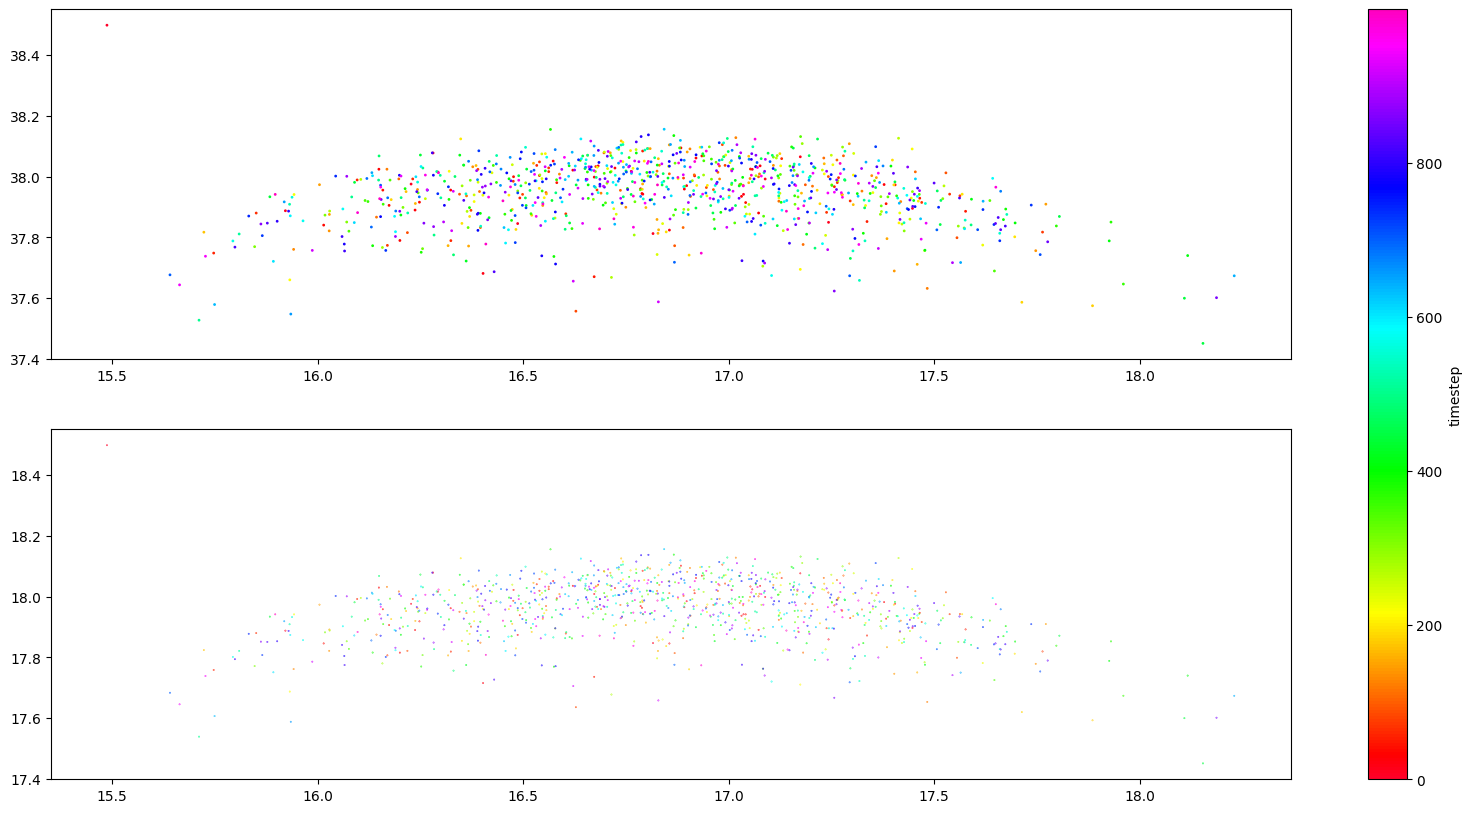

In [16]:
# LEGACY PLOTTING TOOL
render_everyN = 1
orthogonal_distance = np.linalg.norm(headhist[::render_everyN, 1:3]-[20,20], axis=1)
time_arr = np.arange(steps/(render_everyN*hist_every))

#fig, ax = plt.subplots(2, gridspec_kw={'height_ratios': [4, 4]}, figsize=(10, 10))
#fig, ax = plt.subplots(2,gridspec_kw={'height_ratios': [4, 4], "width_ratios": [1]}, figsize=(10,10))
fig, ax = plt.subplots(2, figsize=(20,10), dpi=100)
pos = ax[0].scatter(headhist[::render_everyN, 0], headhist[::render_everyN, 1], cmap="gist_rainbow", c=time_arr, s=1)
#ax[0].set_xlim(4.6, 6.4)
#ax[0].set_ylim(-2.4, 2.4)
#ax[0].set_aspect("equal", adjustable="box")
perp = ax[1].scatter(headhist[::render_everyN, 0], orthogonal_distance[::], cmap="gist_rainbow", c=time_arr, s=0.1)
#ax[1].set_xlim(-0.6, 7.4)
#ax[1].set_ylim(0.5, 4.5)
#ax[1].set_aspect("equal", adjustable="box")
fig.colorbar(pos, ax=ax, label='timestep')
plt.show()

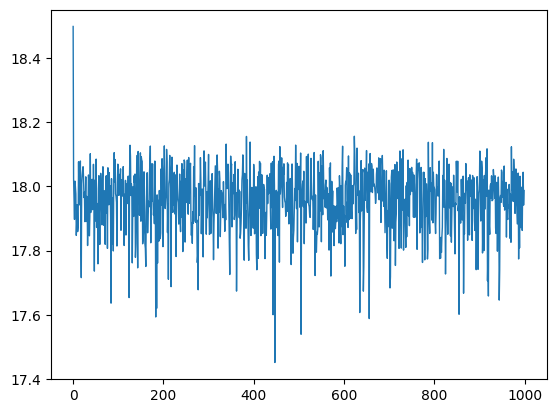

In [17]:
fig, ax = plt.subplots(dpi=100)
figigi = ax.plot(time_arr[::], orthogonal_distance[::], linewidth=1)

In [ ]:
with open("trajectoryn.xyz", "w") as f:
    for t, positions in enumerate(np.concatenate(((np.reshape(headhist[::],(int(steps/hist_every),1,3))), surfacehist[::]),axis=1)):
        f.write(f"6 \n \n")
        f.write(f"C1 {positions[0,0]:8.4f}{positions[0,1]:8.4f}{positions[0,2]:8.4f} \n")
        f.write(f"C2 {positions[1,0]:8.4f}{positions[1,1]:8.4f}{positions[1,2]:8.4f} \n")
        f.write(f"C3 {positions[2,0]:8.4f}{positions[2,1]:8.4f}{positions[2,2]:8.4f} \n")
        f.write(f"C4 {positions[3,0]:8.4f}{positions[3,1]:8.4f}{positions[3,2]:8.4f} \n")
        f.write(f"C5 {positions[4,0]:8.4f}{positions[4,1]:8.4f}{positions[4,2]:8.4f} \n")
        f.write(f"C6 {positions[5,0]:8.4f}{positions[5,1]:8.4f}{positions[5,2]:8.4f} \n")

In [ ]:
    with open("polymerrn.xyz", "w") as f:
        f.write(f"2800 \n \n")
        for i in range(polymerLength*14):
            f.write(f"C{2*i+7} {polymersurfaceP[i,0]:8.4f}{polymersurfaceP[i,1]:8.4f}{polymersurfaceP[i,2]:8.4f} \n")
            f.write(f"C{2*i+8} {polymersurfaceN[i,0]:8.4f}{polymersurfaceN[i,1]:8.4f}{polymersurfaceN[i,2]:8.4f} \n")
    #for i in range(polymerLength):
     #   f.write(f"ATOM  {i+2:5d}  C   UNK     1    {i:8.4f}{0:8.4f}{0:8.4f}  1.00  0.00           C\n")

Starting 8 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


  0%|          | 0/8 [00:00<?, ?engine/s]

importing time on engine(s)
Engine 0:


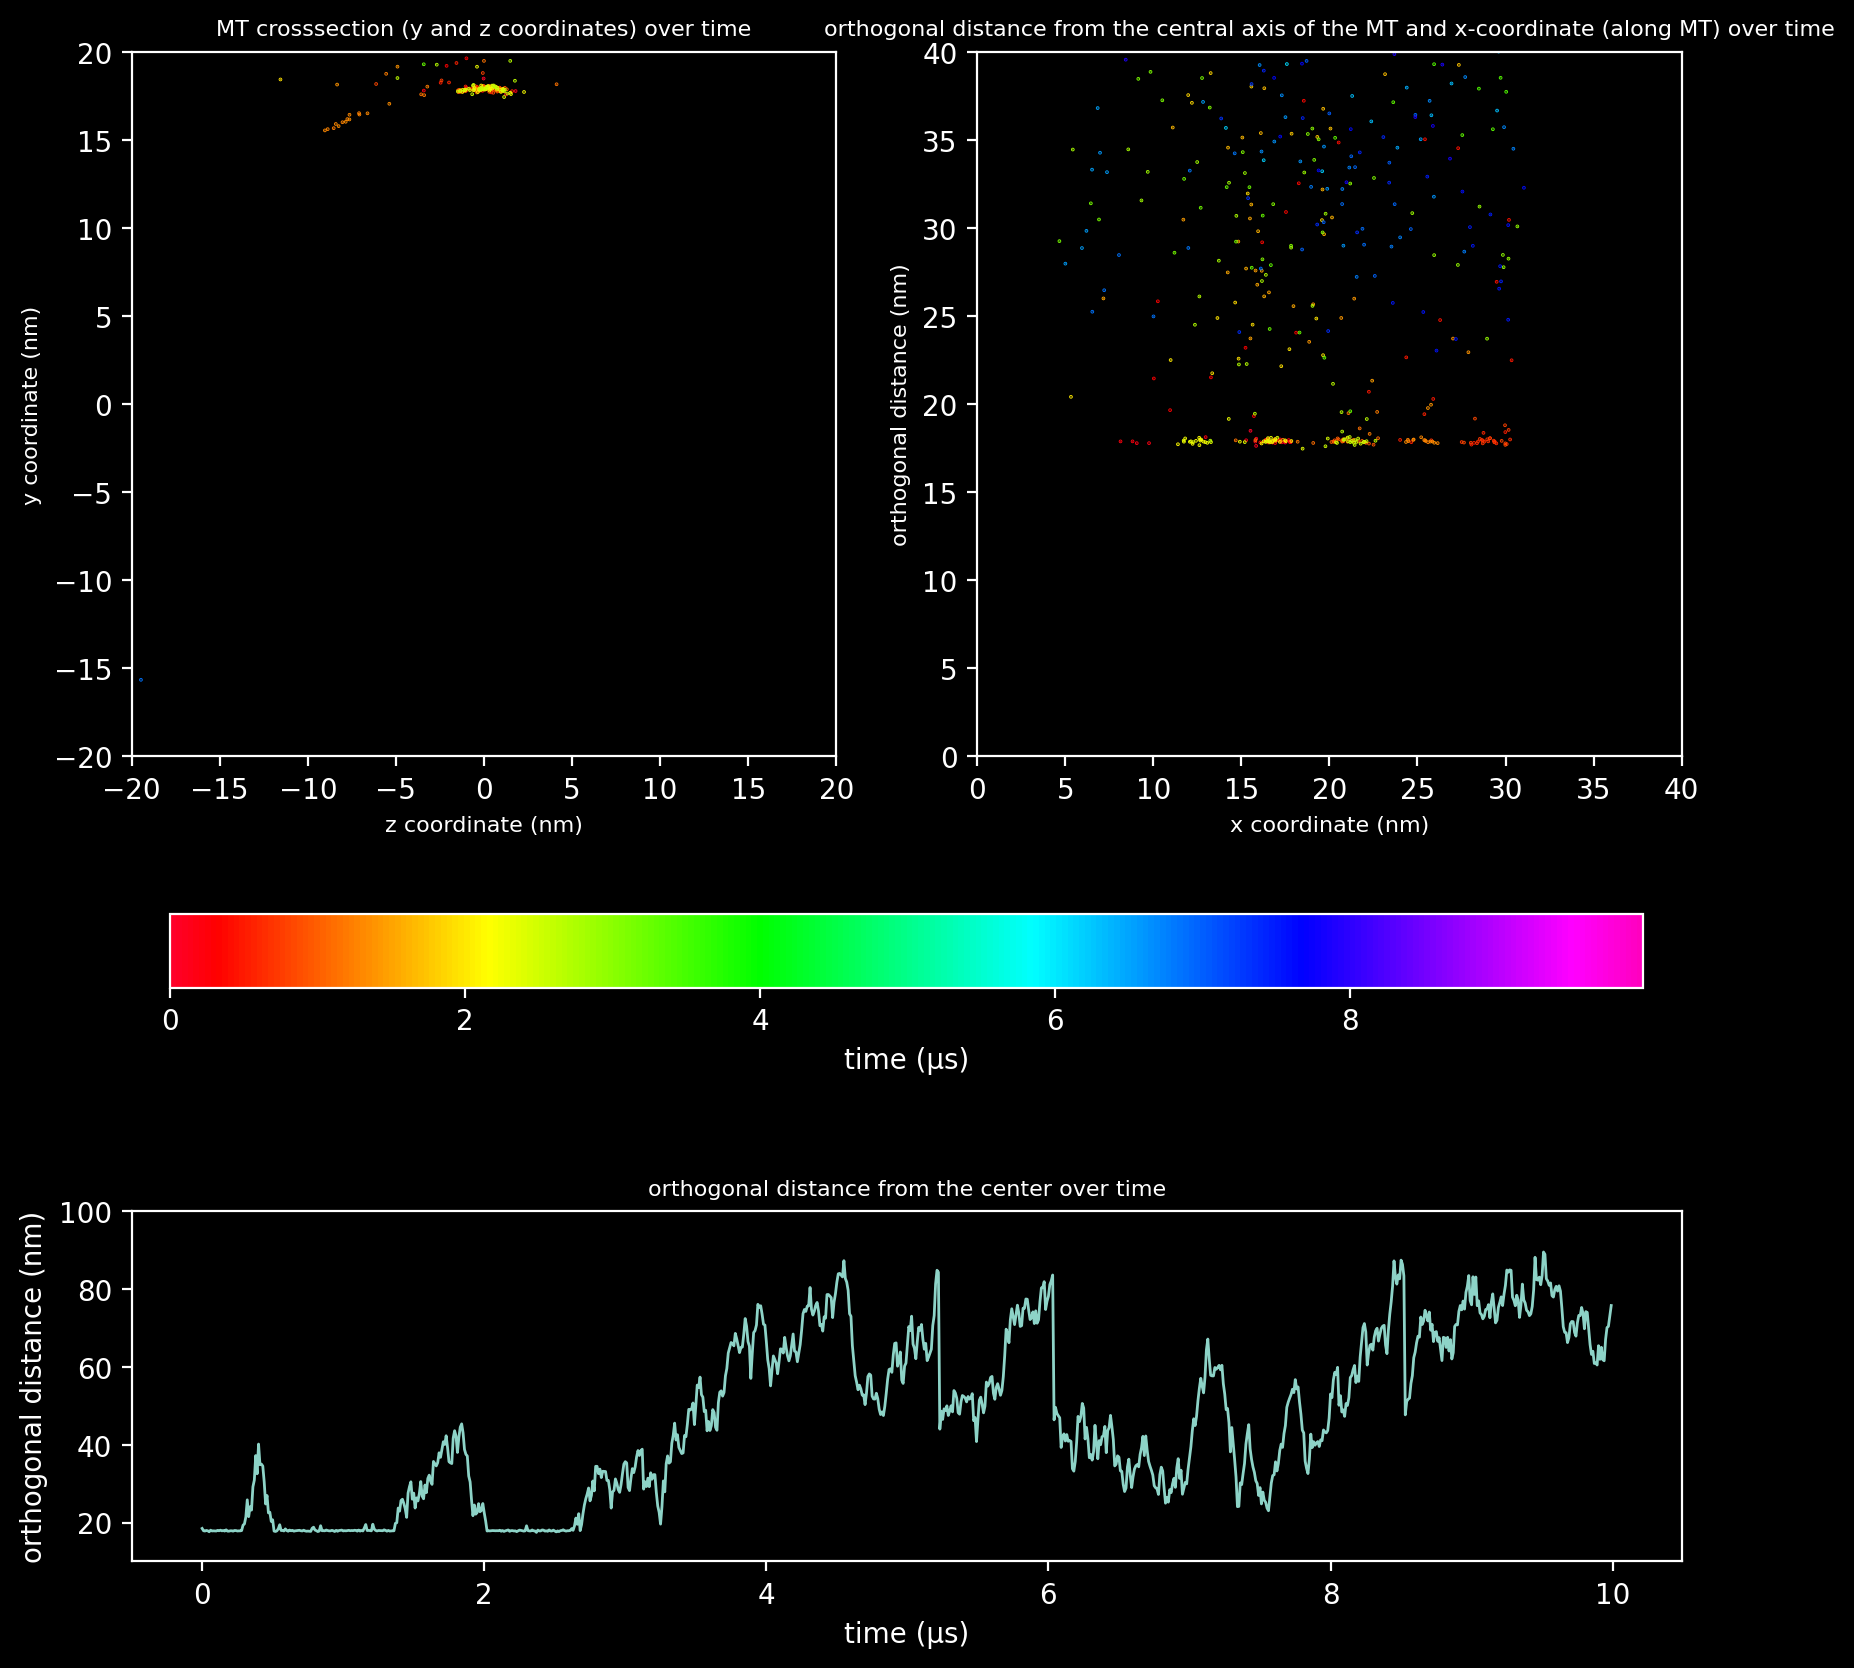

engine set stopped 1742414865: {'engines': {'1': {'exit_code': 0, 'pid': 3136, 'identifier': '1'}, '0': {'exit_code': 0, 'pid': 3135, 'identifier': '0'}, '5': {'exit_code': 0, 'pid': 3146, 'identifier': '5'}, '3': {'exit_code': 0, 'pid': 3139, 'identifier': '3'}, '6': {'exit_code': 0, 'pid': 3152, 'identifier': '6'}, '7': {'exit_code': 0, 'pid': 3158, 'identifier': '7'}, '4': {'exit_code': 0, 'pid': 3144, 'identifier': '4'}, '2': {'exit_code': 0, 'pid': 3137, 'identifier': '2'}}, 'exit_code': 0}
Elapsed (after compilation) = 213.94601720798528s
Engine 1:


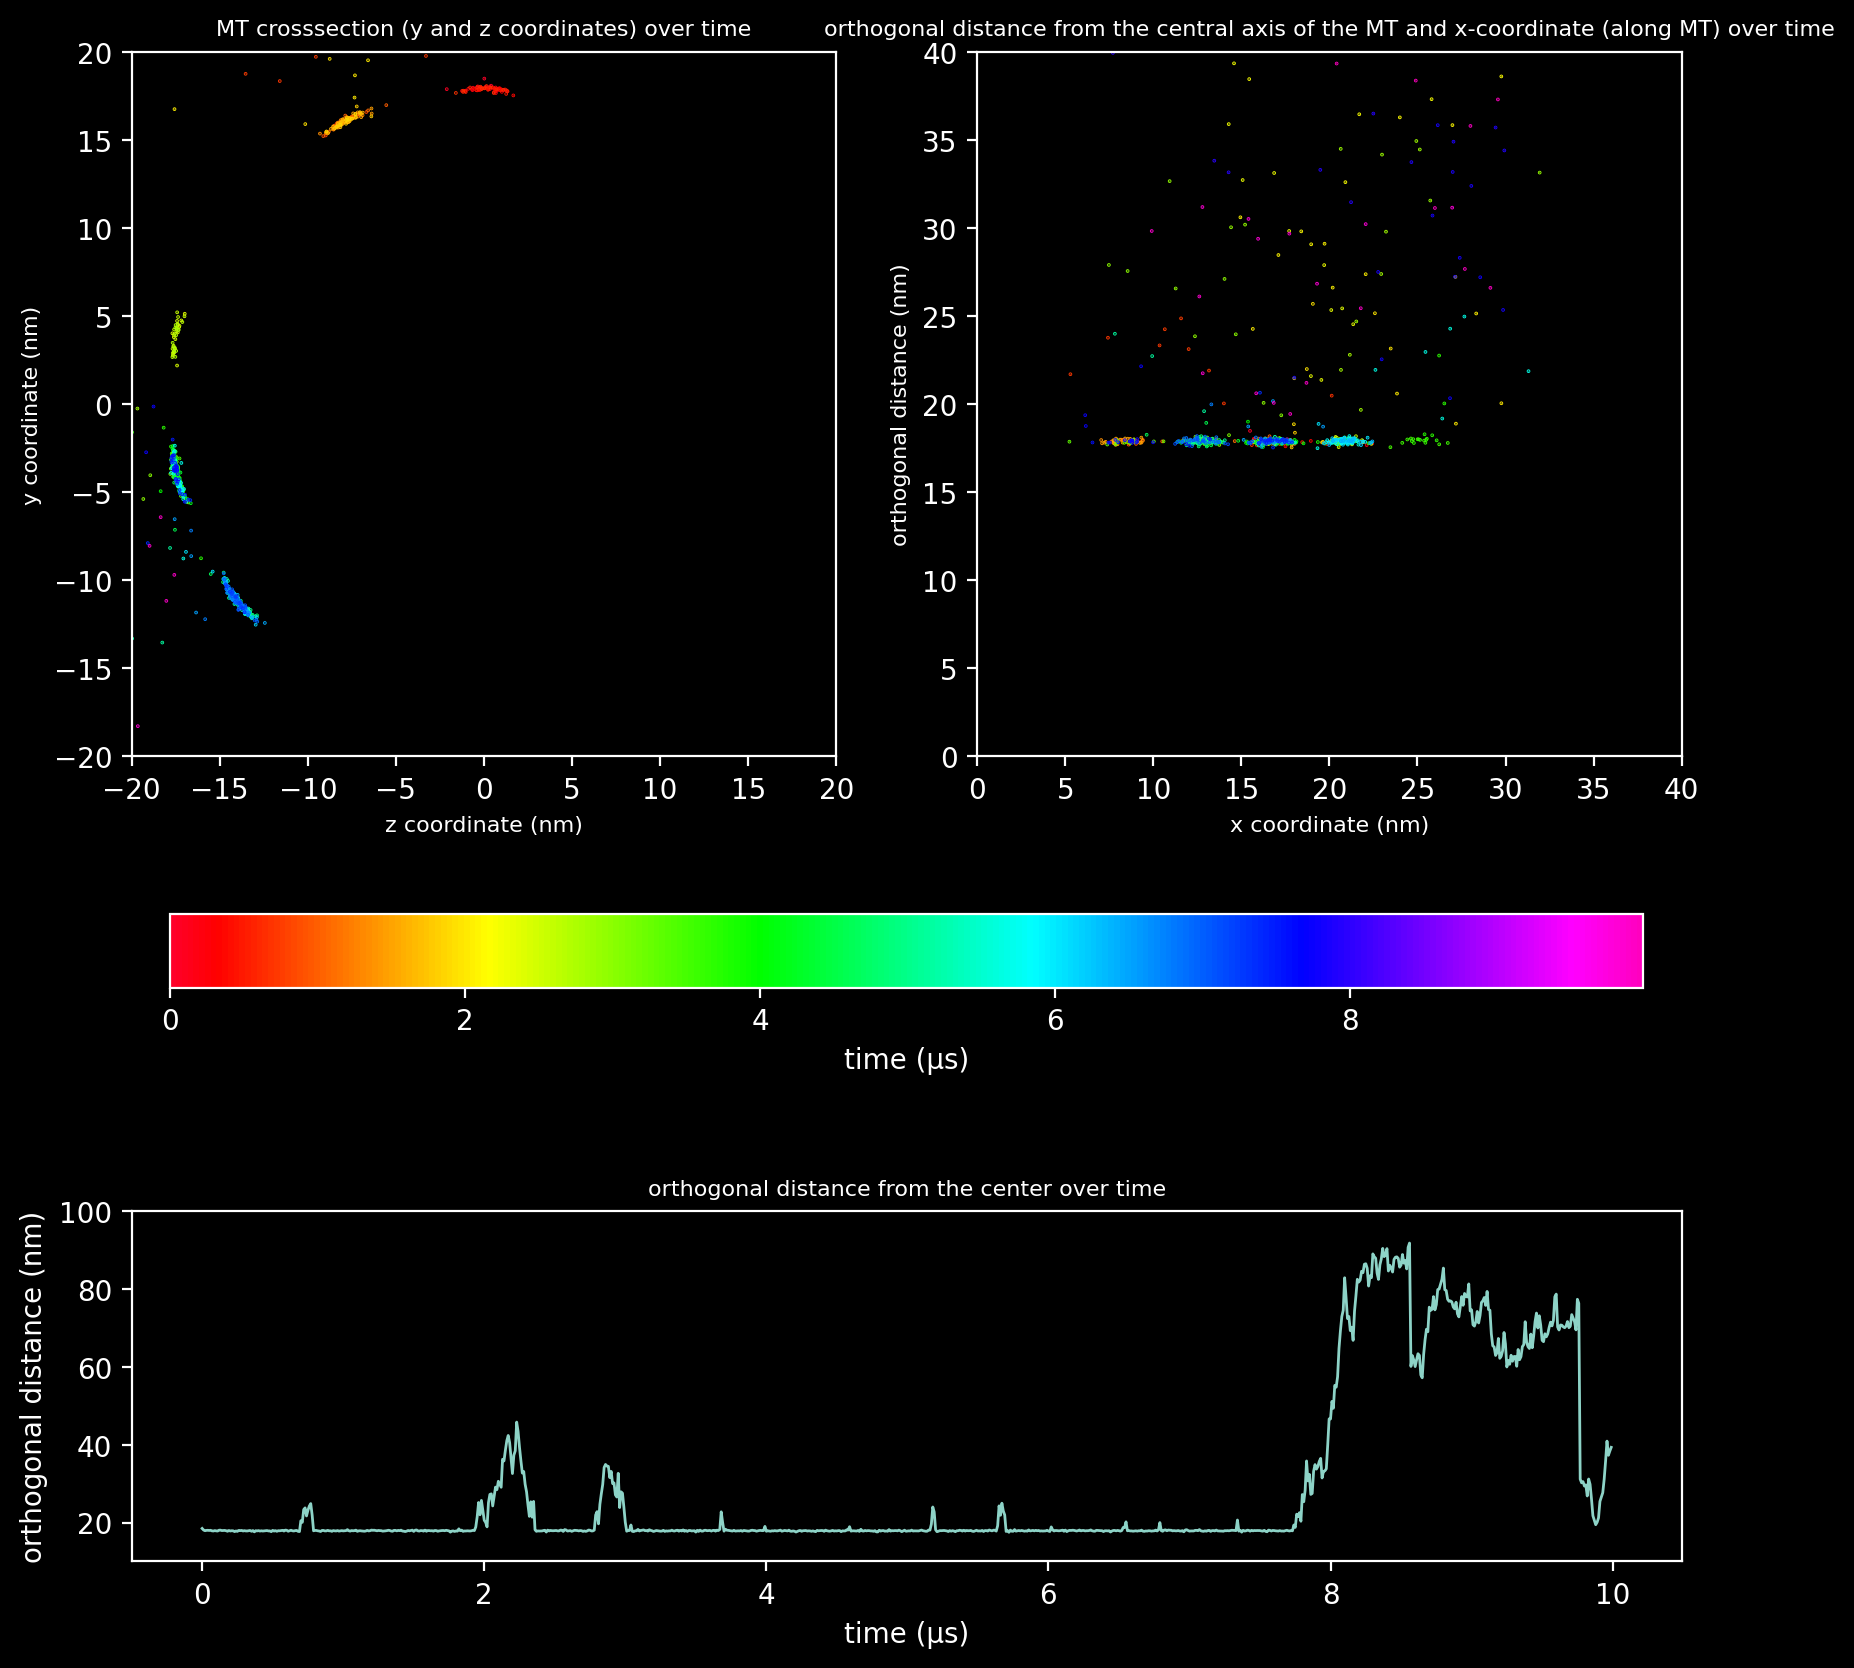

Elapsed (after compilation) = 209.25706937498762s
Engine 2:
Controller stopped: {'exit_code': 0, 'pid': 3120, 'identifier': 'ipcontroller-1742414864-5b6g-532'}


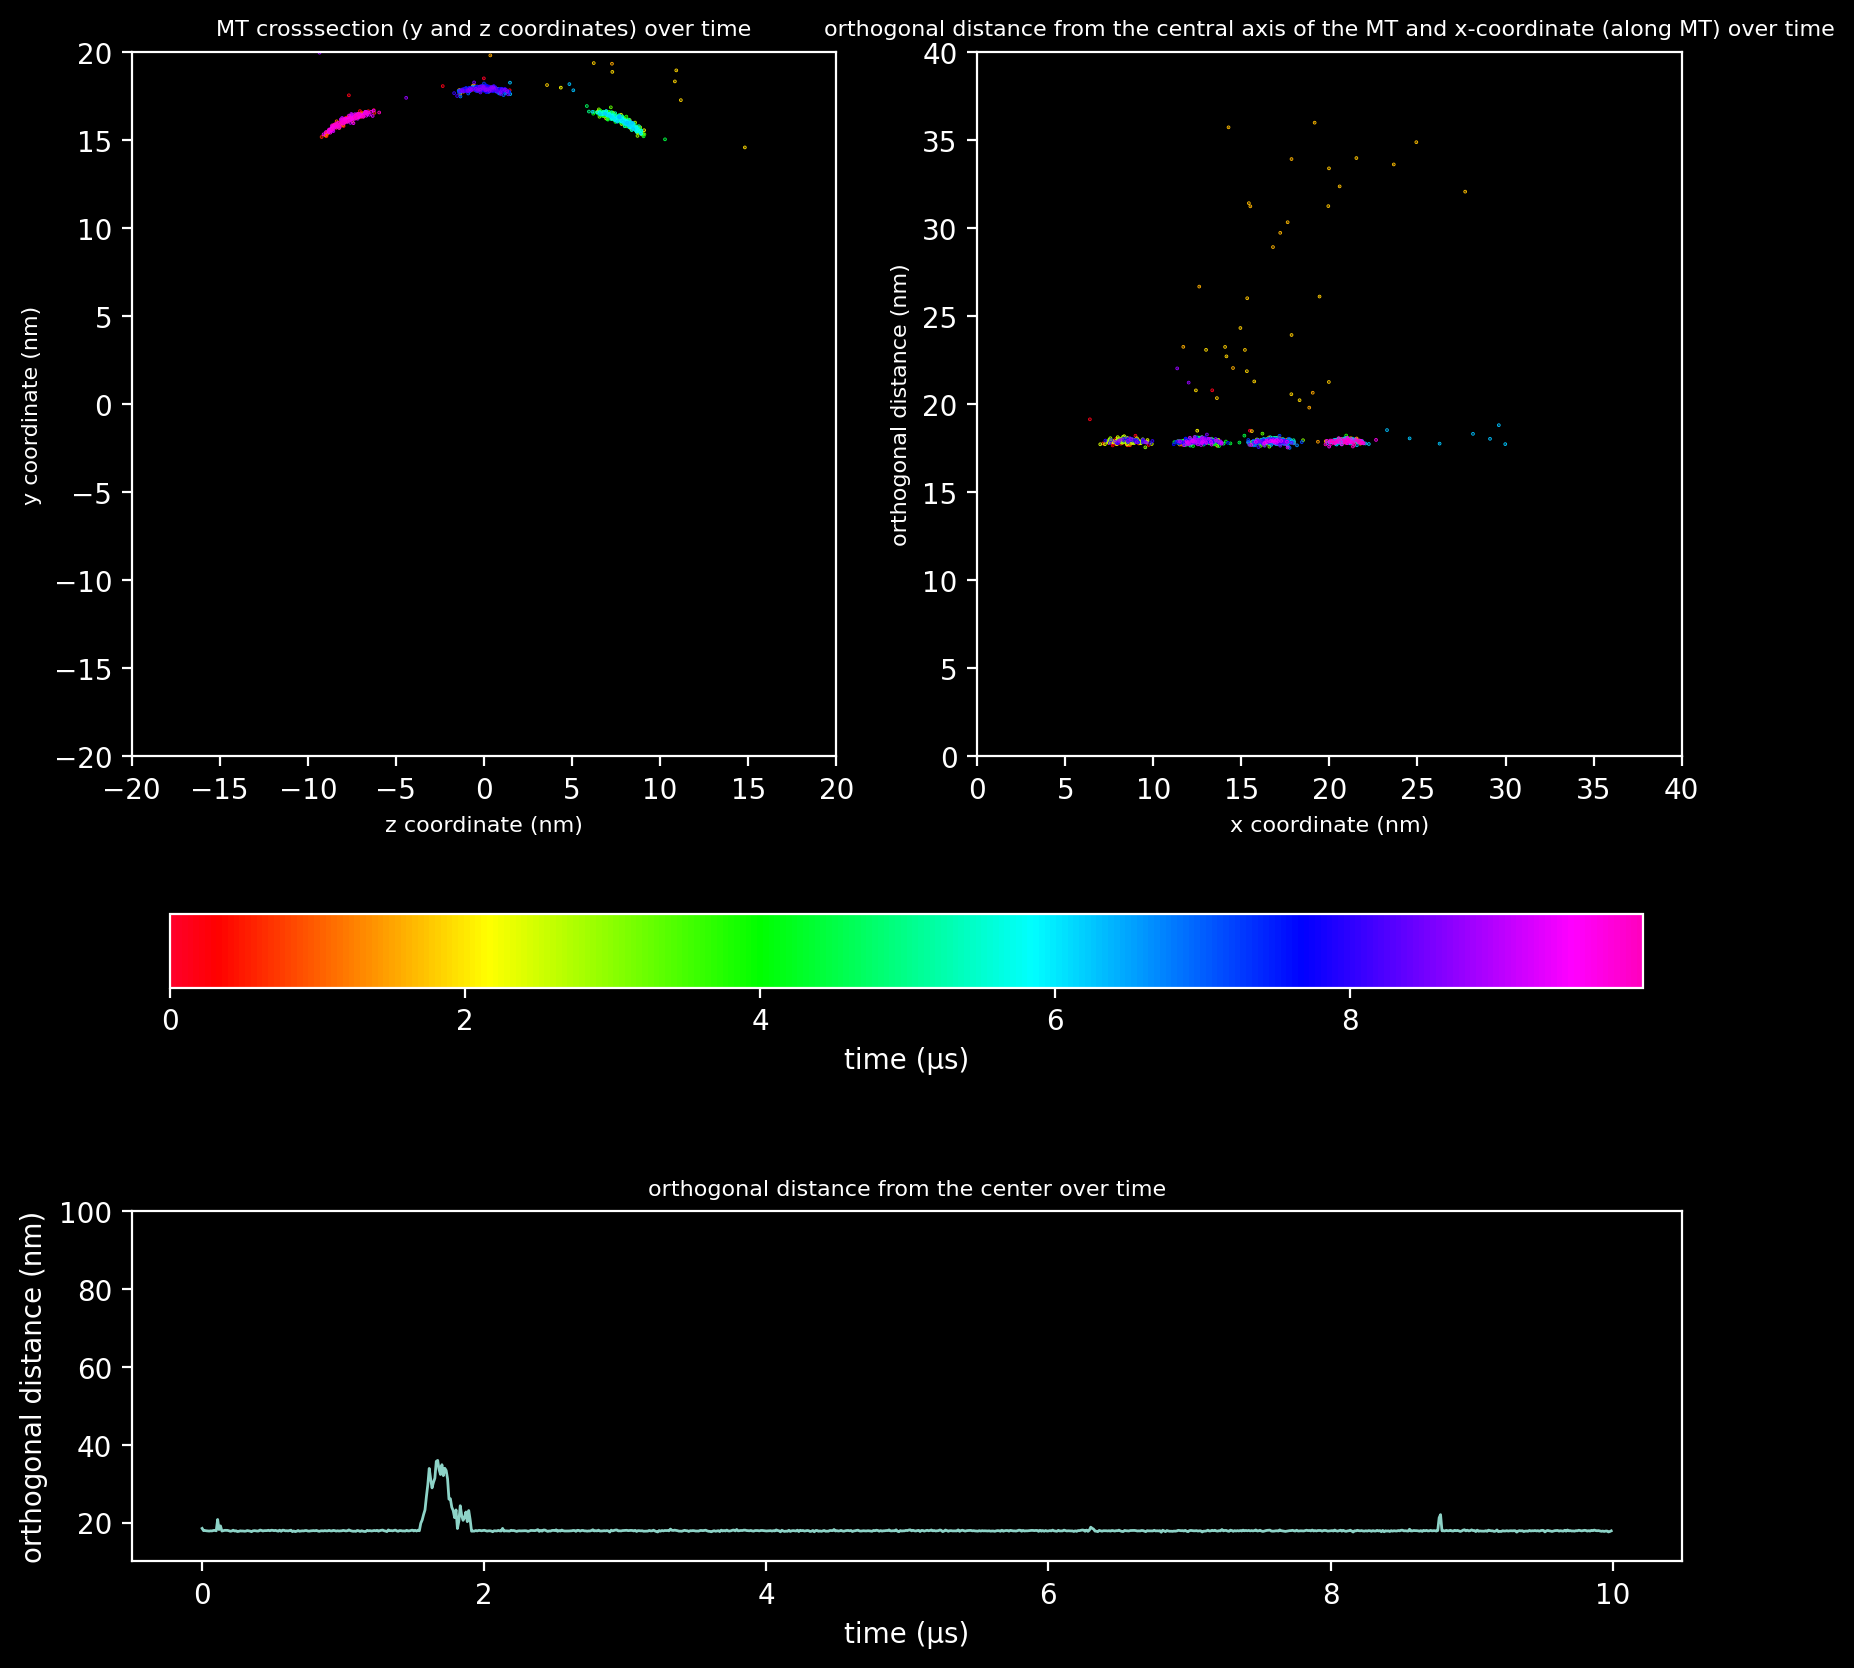

Elapsed (after compilation) = 208.51621408300707s
Engine 3:


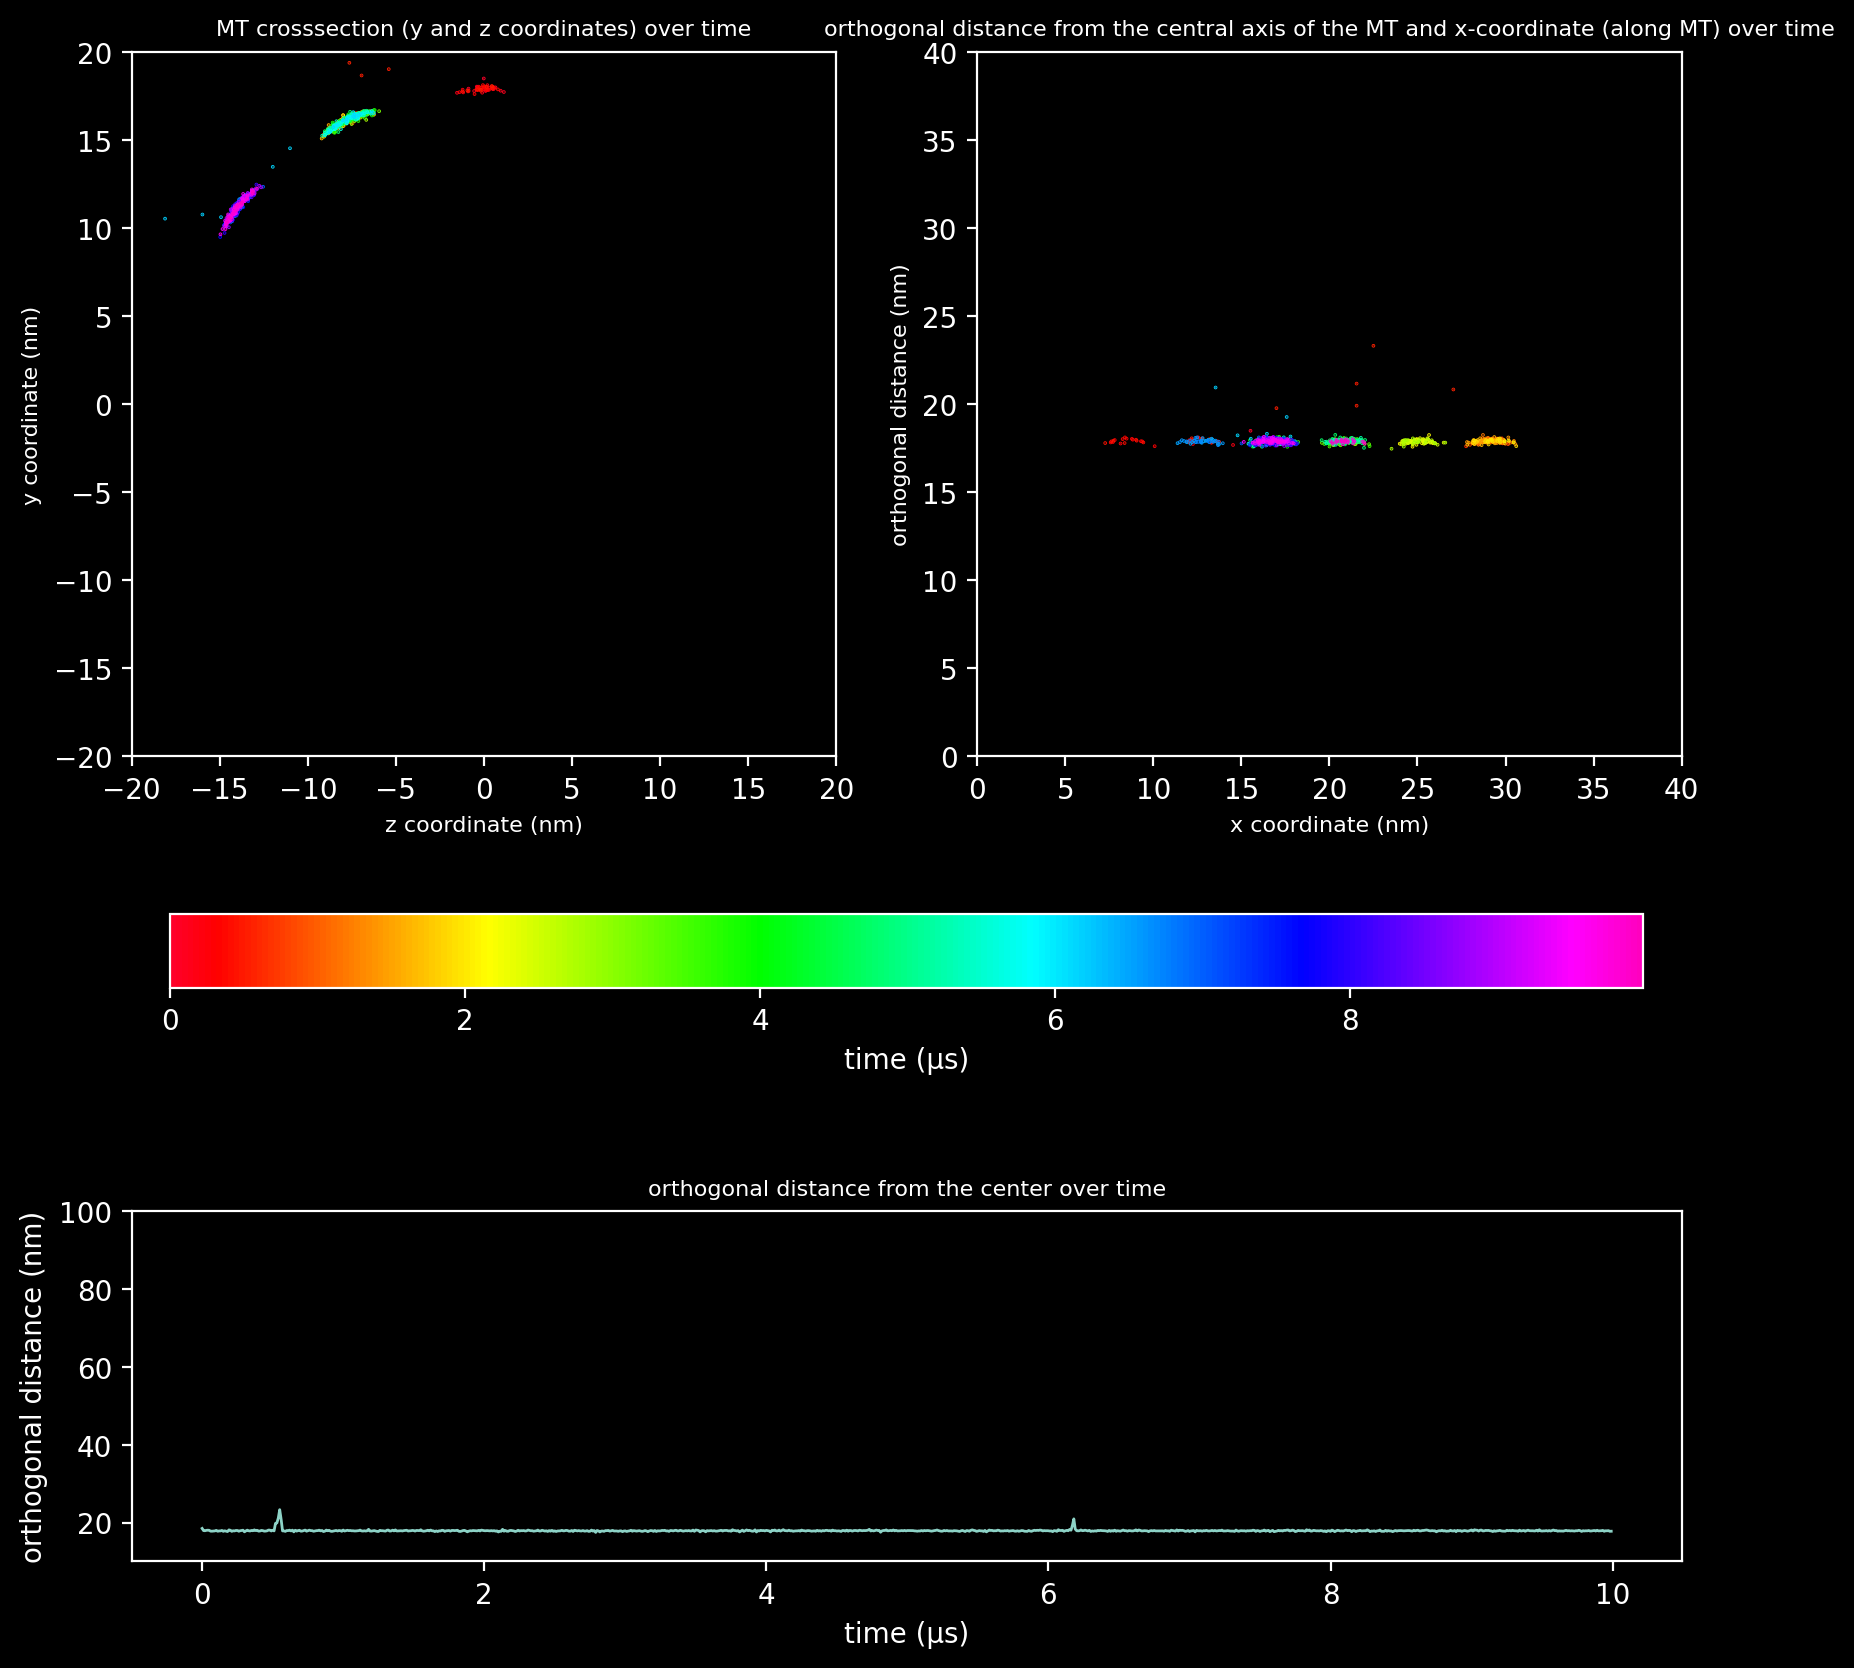

Elapsed (after compilation) = 218.24073345898069s
Engine 4:


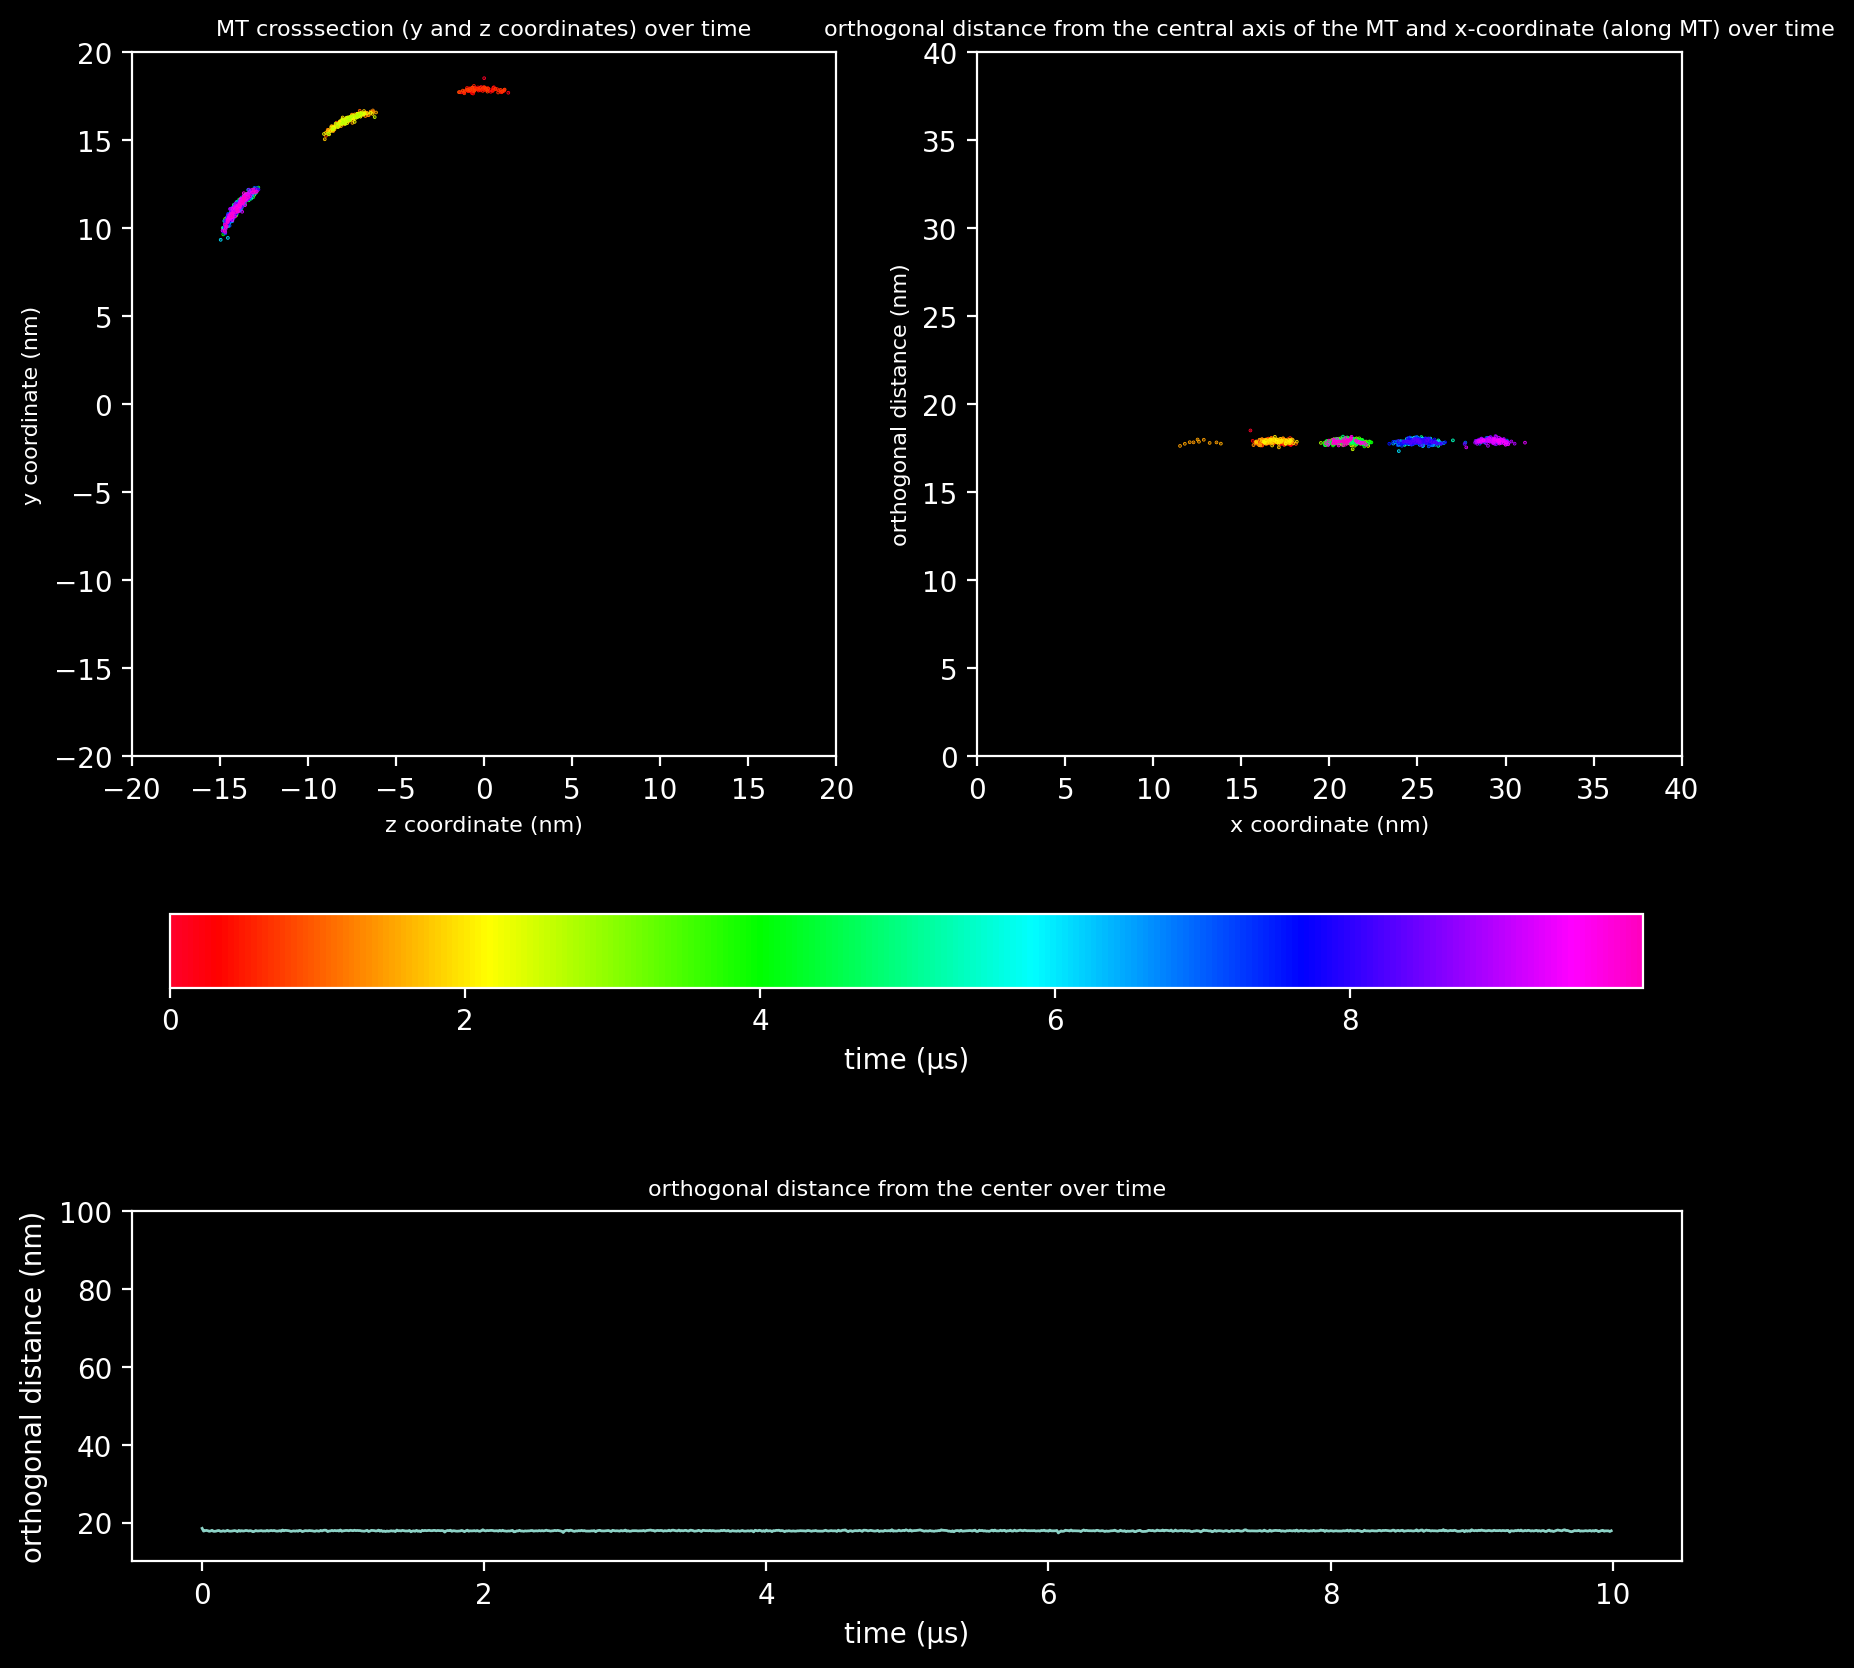

Elapsed (after compilation) = 219.27664145897143s
Engine 5:


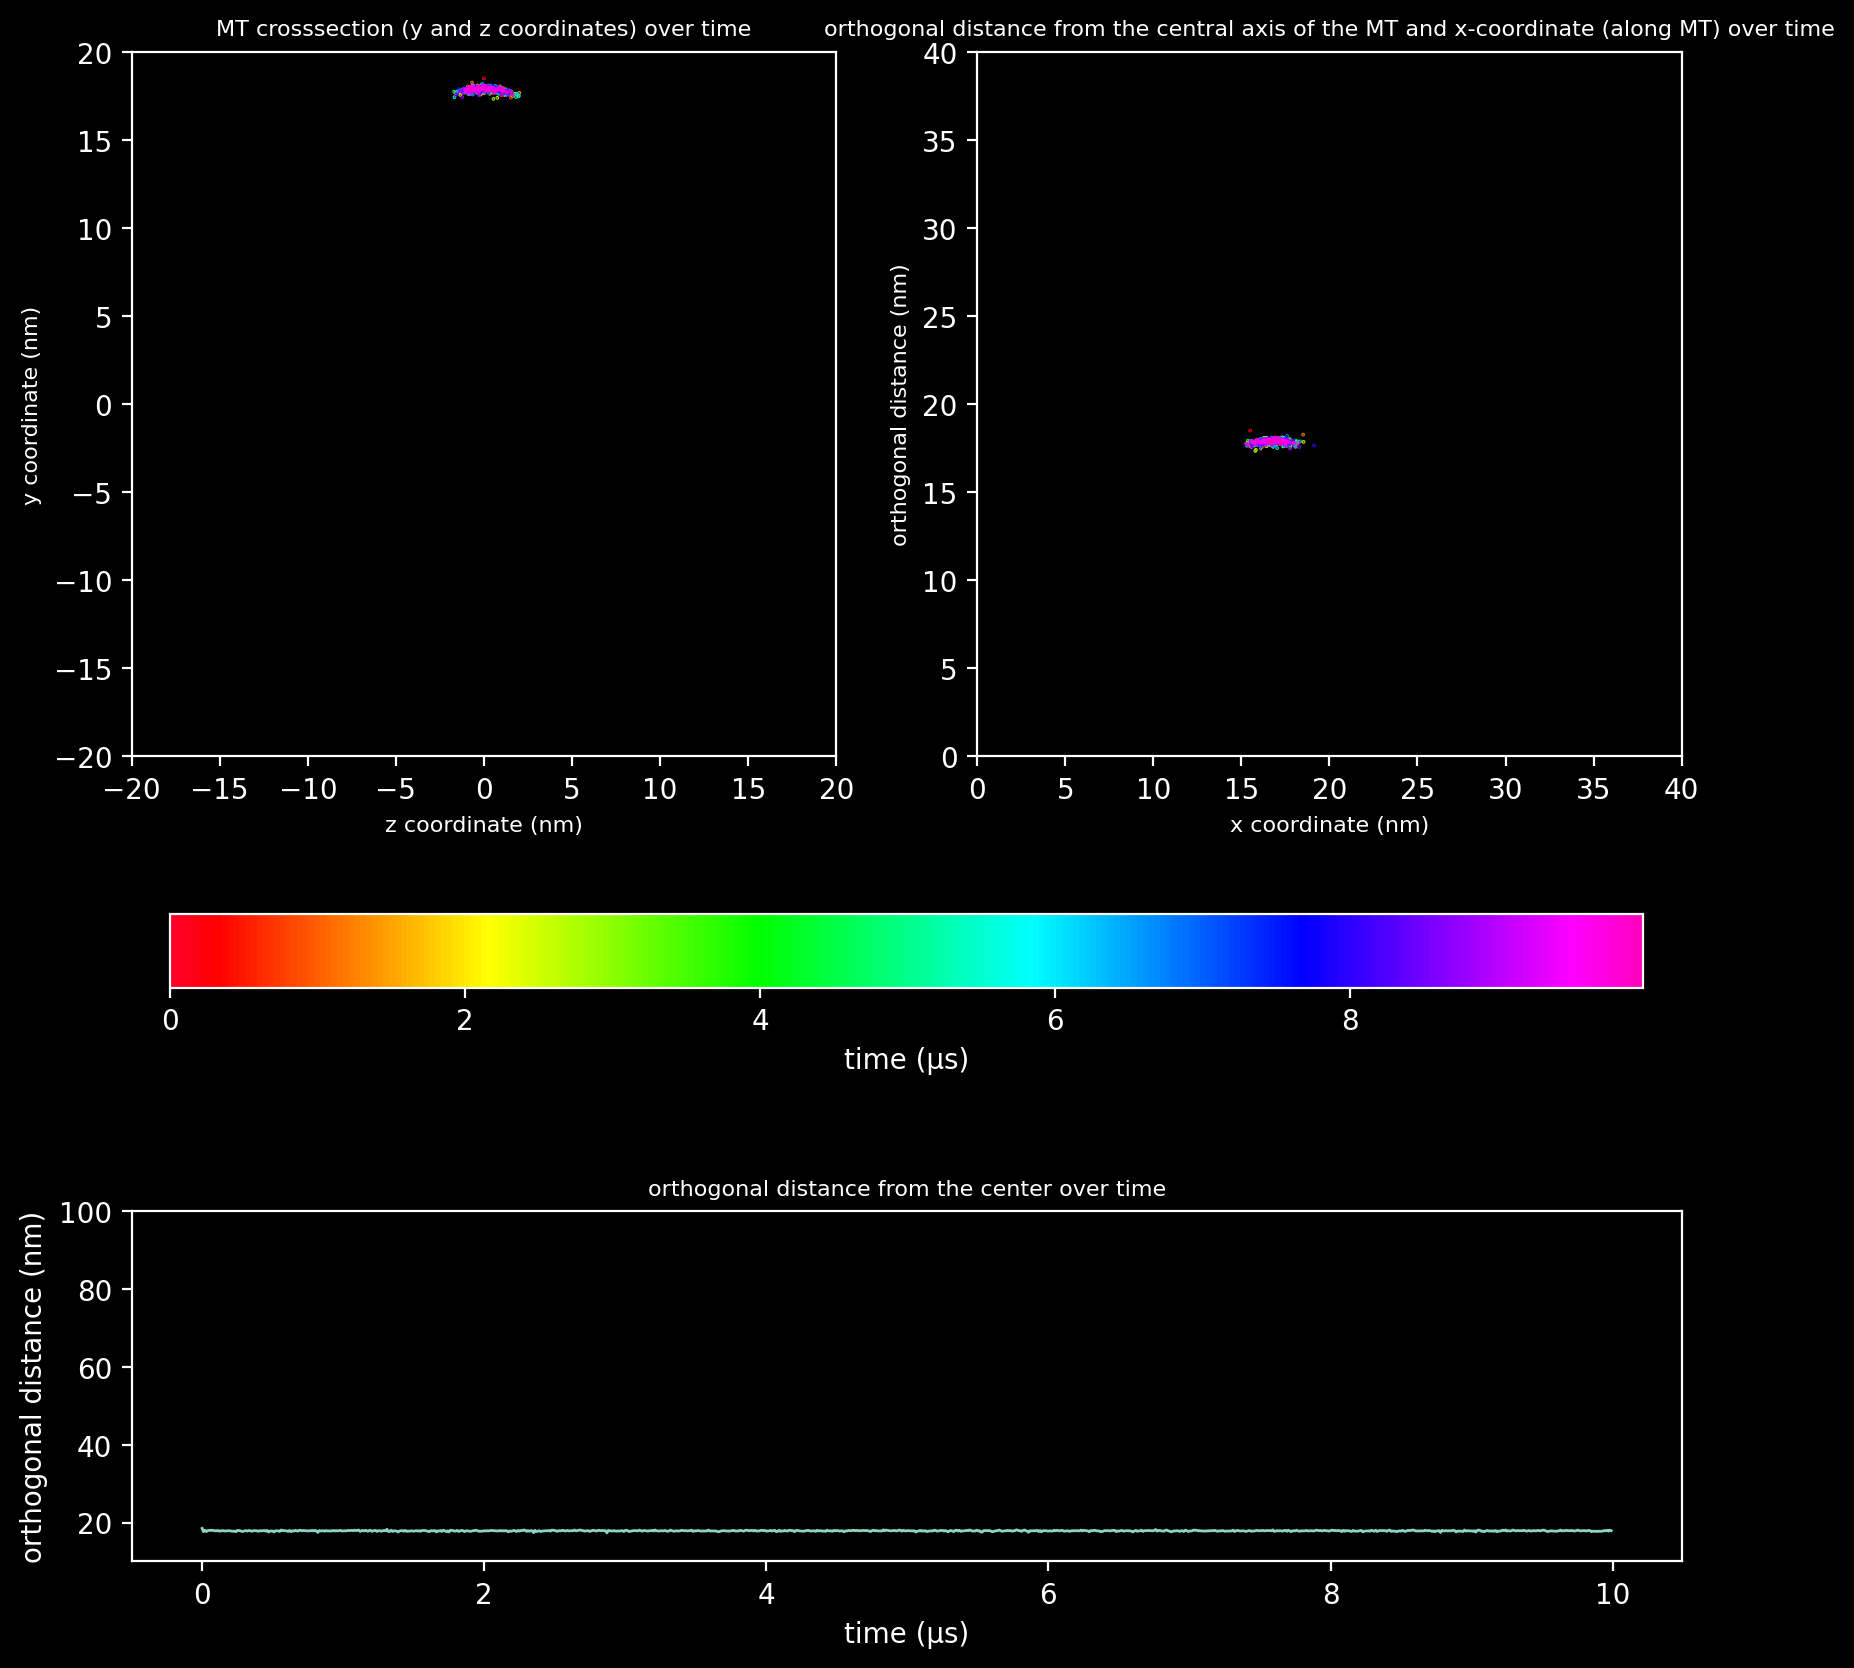

Elapsed (after compilation) = 217.5584039169771s
Engine 6:


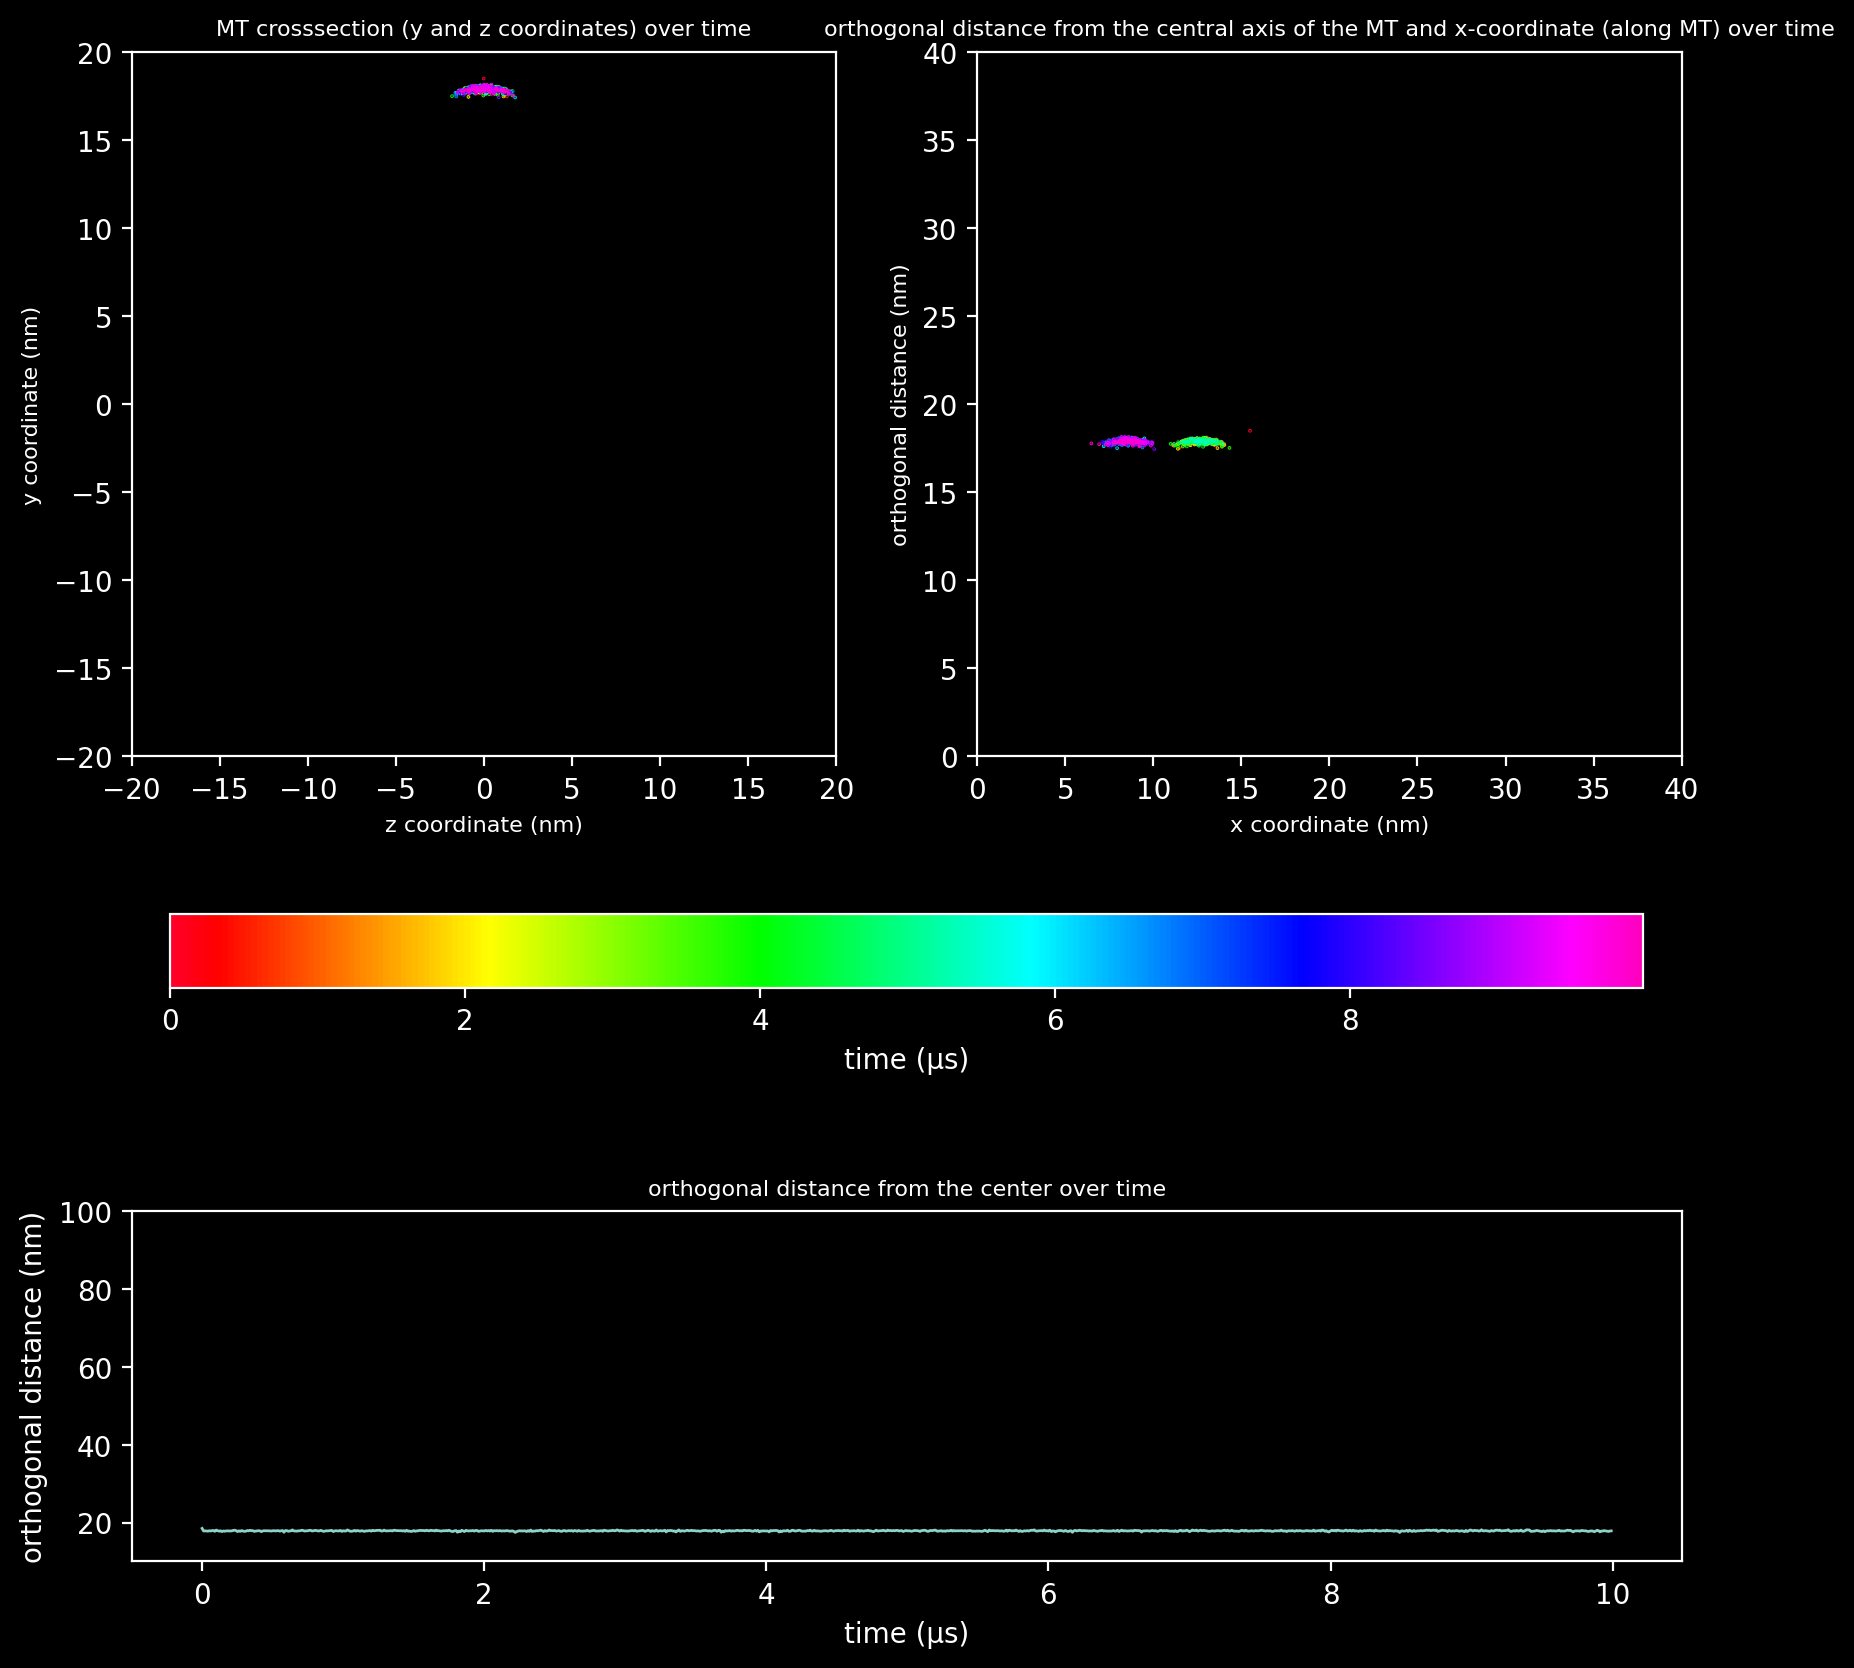

Elapsed (after compilation) = 215.3007654999965s
Engine 7:


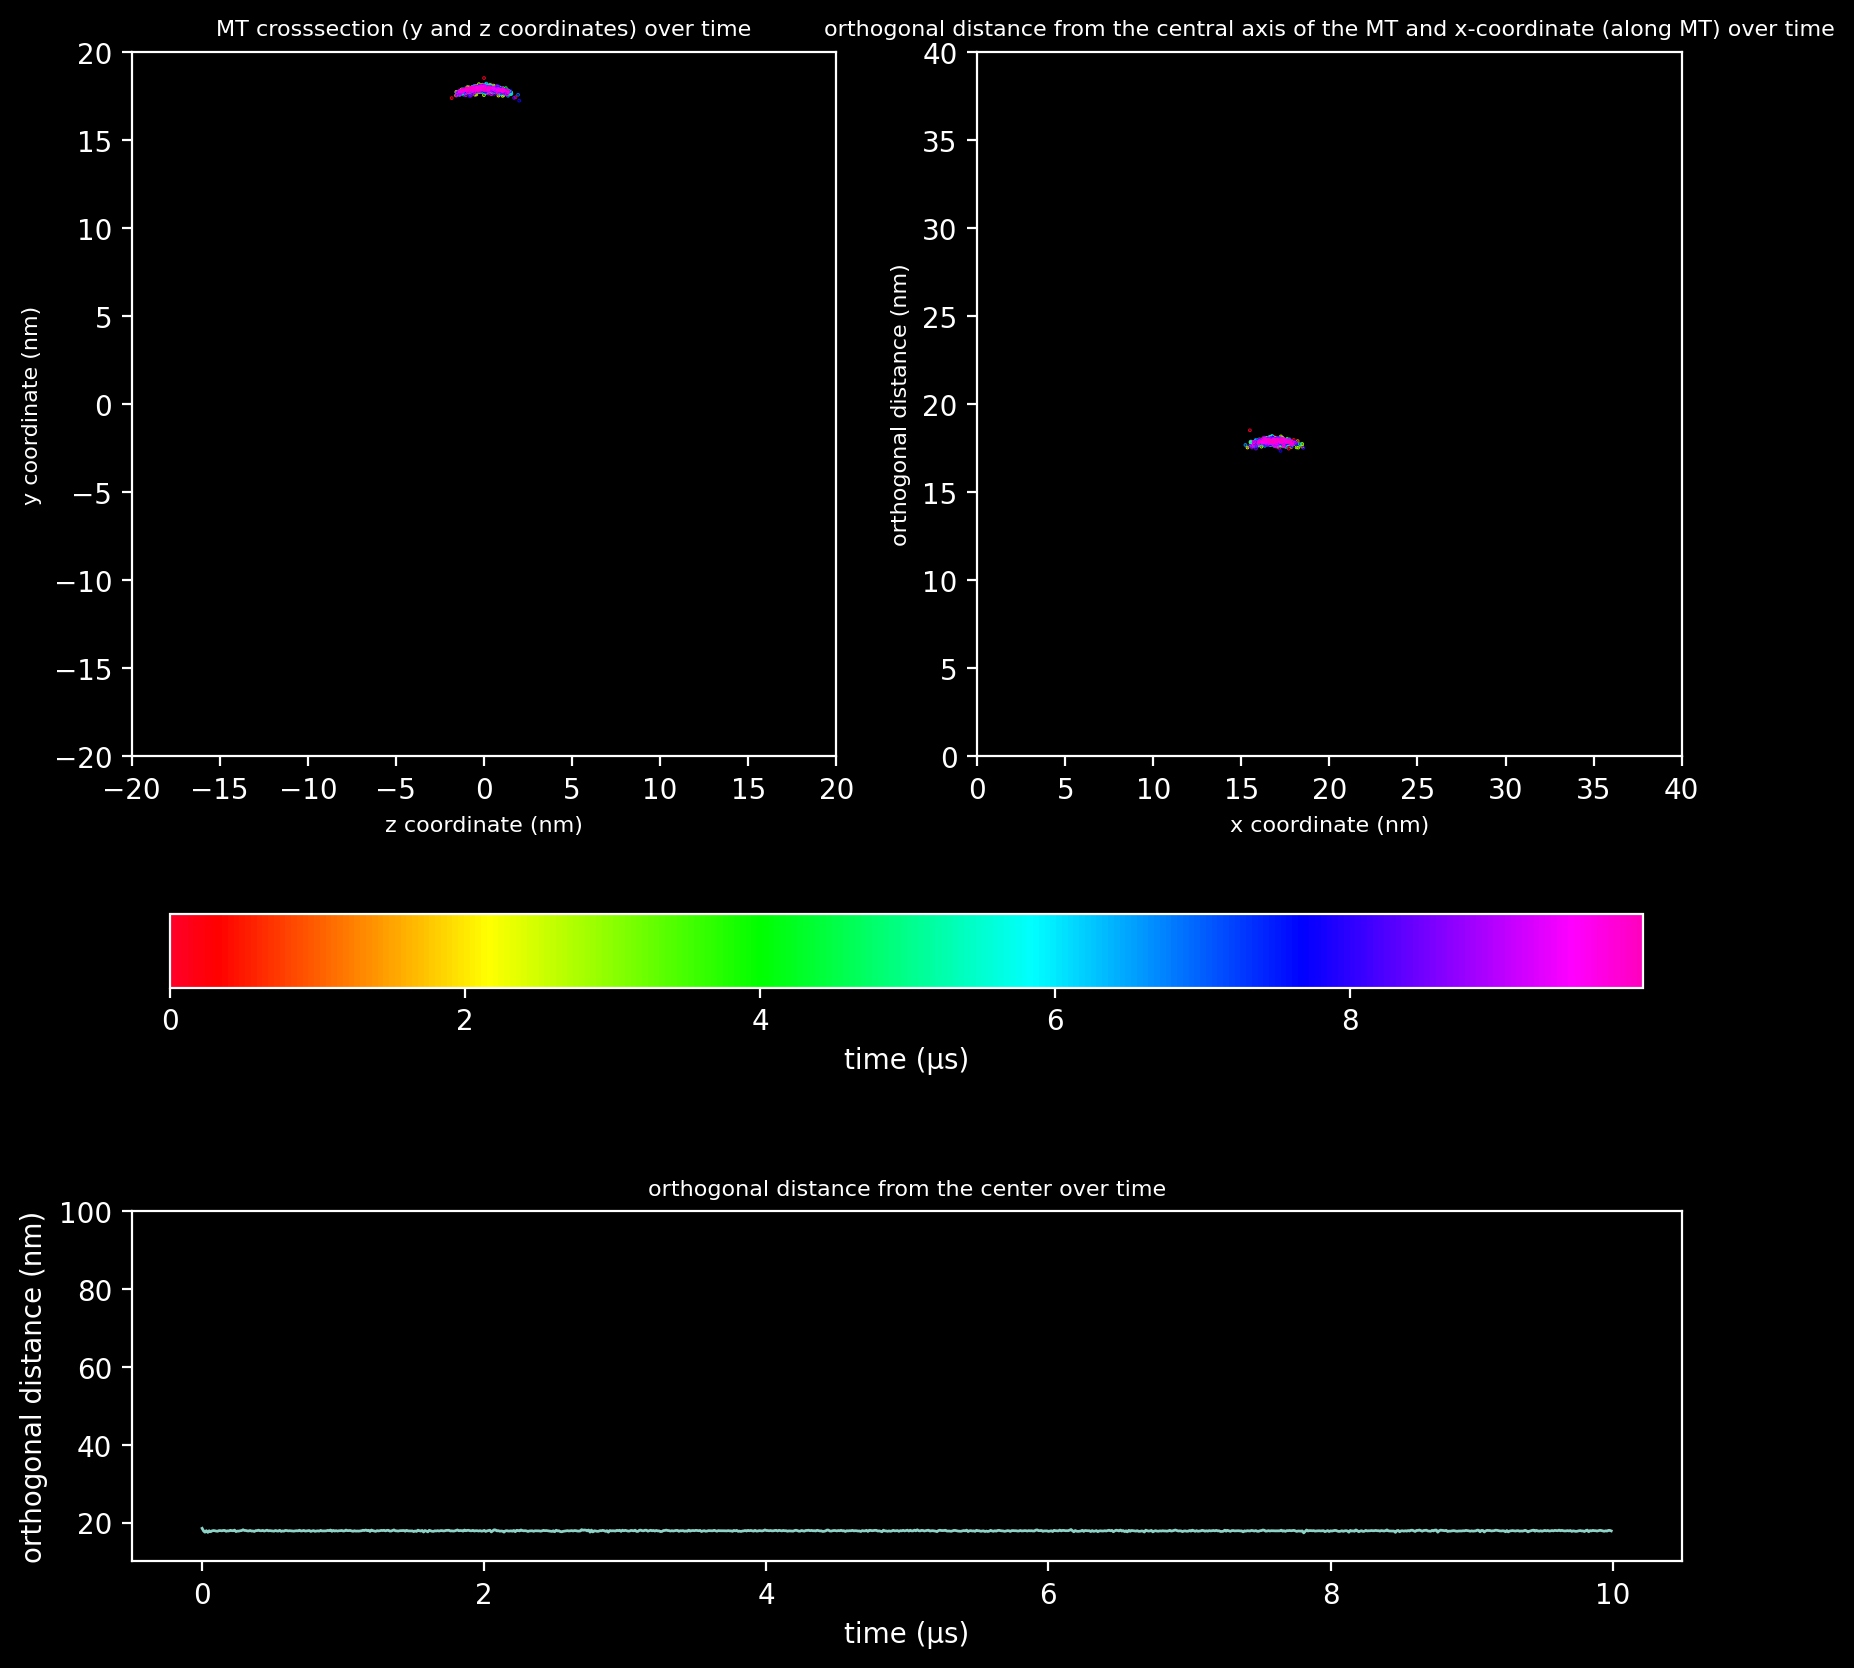

Elapsed (after compilation) = 216.18604512501042s


In [41]:
# MULTICORE

import ipyparallel as ipp


polymerLength = 10
headN = 1
steps = 100000000
dt = 100            # fs
mu = 0.01           # fs mol/g, 0.01 gives the viscosity of the medium ~ 5.34 mPa*s
print_every = 100000000
hist_every = 100000
unit_distanceX = 4.13 # nm
temp = 311.4            # K
random_val = np.sqrt(2.0*8.314*(10.0**-3) * mu * temp)/1000.0
n_proc = 8
rc = ipp.Cluster(n=n_proc).start_and_connect_sync()
rc.ids
dview = rc[:]  # get a DirectView of all engines

# Push the necessary simulation functions and parameters to each engine.
# Adjust the names as needed to match your notebook's variables.
dview.push({
    'simulate': simulate,
    'polymergenerator': polymergenerator,
    'polymerLength': polymerLength,
    'headN': headN,
    'steps': steps,
    'dt': dt,
    'random_val': random_val,
    'mu': mu,
    'print_every': print_every,
    'hist_every': hist_every
})

# variable epsilon for surface interaction lj
epsilons = []
for n in range(n_proc): epsilons.append((0.0006+0.0001*n)) # epsilons.append((0.0009+0.000010*n)) works well, in GJ/mol
dview.scatter('epsilon', epsilons)

with dview.sync_imports():
    import time

# define run
def run_simulation_instance():
    print(epsilon)
    start = time.perf_counter()
    polymer, COM, surface, polymersurfaceP, polymersurfaceN = polymergenerator(polymerLength, headN)
    headhist, surfacehist = simulate(COM, surface, polymer, polymersurfaceP, polymersurfaceN, steps, dt, random_val, mu, print_every, hist_every, epsilon[0])
    end = time.perf_counter()
    elapsed = end - start
    return {'headhist': headhist, 'surfacehist': surfacehist, 'elapsed': elapsed}

# run
async_results = dview.apply_async(run_simulation_instance)

# get results and shutdown engines
results = async_results.get()
rc.shutdown(hub=True)

# plot for each
for idx, res in enumerate(results):
    print(f"Engine {idx}:")
    plotter(res['headhist'], idx, True)
    print("Elapsed (after compilation) = {}s".format((res['elapsed'])))


In [26]:
     # output trajectory to .xyz
for idx, res in enumerate(results):
    with open(f"trajectoryn{idx}.xyz", "w") as f:
        for t, positions in enumerate(np.concatenate(((np.reshape(res['headhist'[::]],(int(steps/hist_every),1,3))), res['surfacehist'][::]),axis=1)):
            f.write(f"6 \n \n")
            f.write(f"C1 {positions[0,0]:8.4f}{positions[0,1]:8.4f}{positions[0,2]:8.4f} \n")
            f.write(f"C2 {positions[1,0]:8.4f}{positions[1,1]:8.4f}{positions[1,2]:8.4f} \n")
            f.write(f"C3 {positions[2,0]:8.4f}{positions[2,1]:8.4f}{positions[2,2]:8.4f} \n")
            f.write(f"C4 {positions[3,0]:8.4f}{positions[3,1]:8.4f}{positions[3,2]:8.4f} \n")
            f.write(f"C5 {positions[4,0]:8.4f}{positions[4,1]:8.4f}{positions[4,2]:8.4f} \n")
            f.write(f"C6 {positions[5,0]:8.4f}{positions[5,1]:8.4f}{positions[5,2]:8.4f} \n")

 # Utilities bellow

Engine 0:


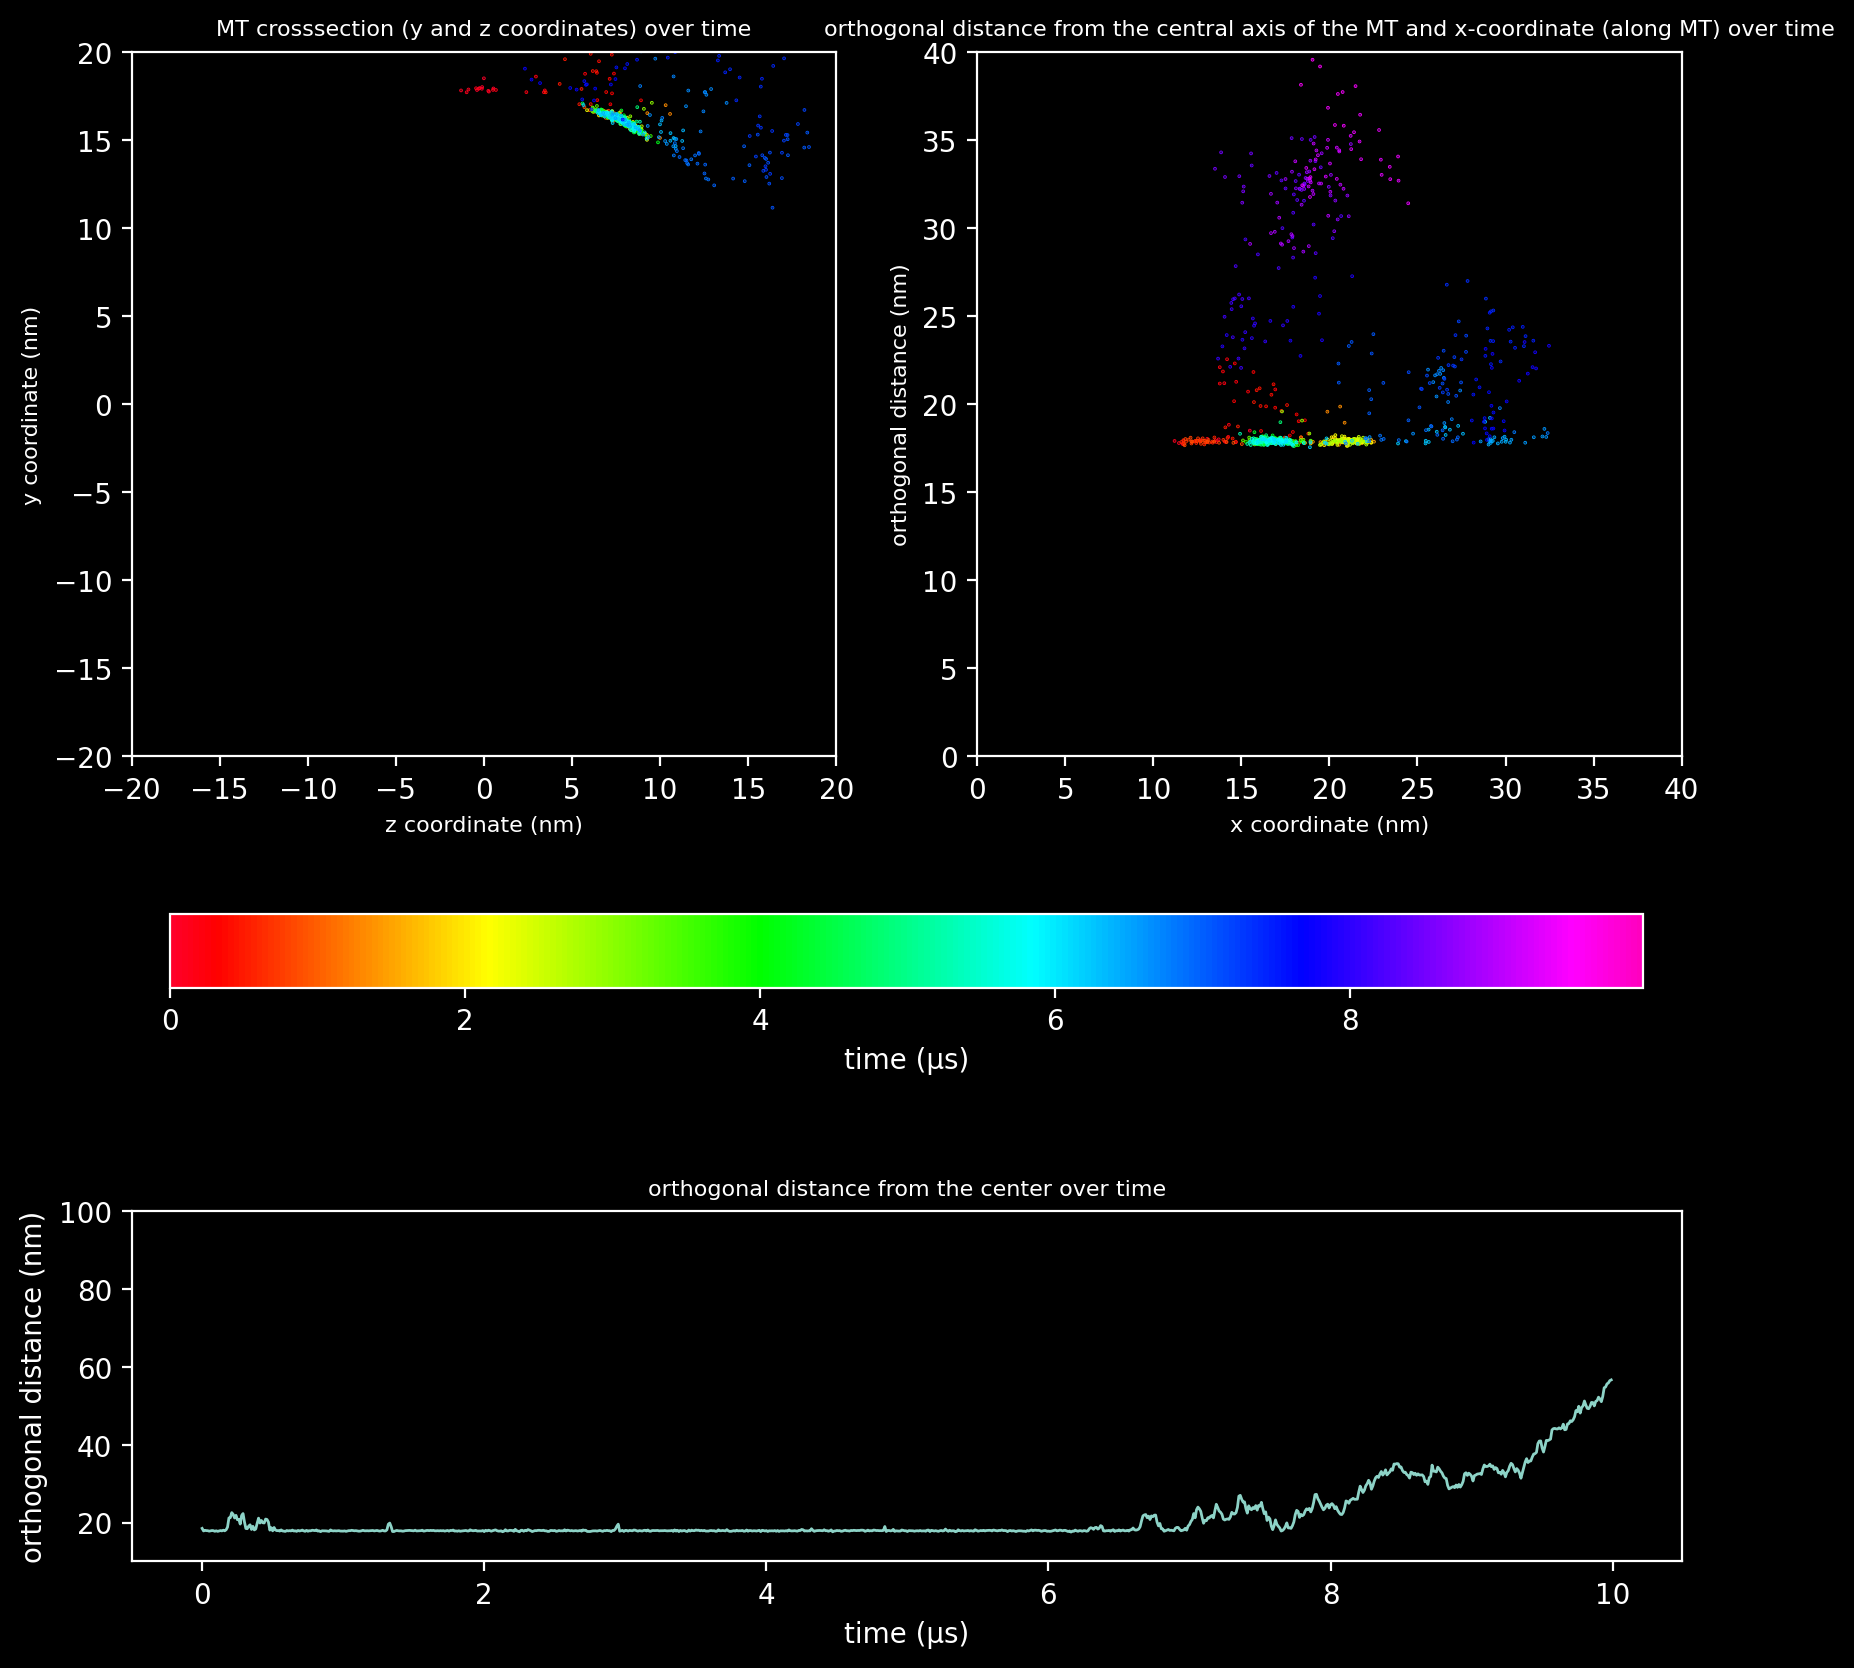

Elapsed (after compilation) = 25.14605537499301s
Engine 1:


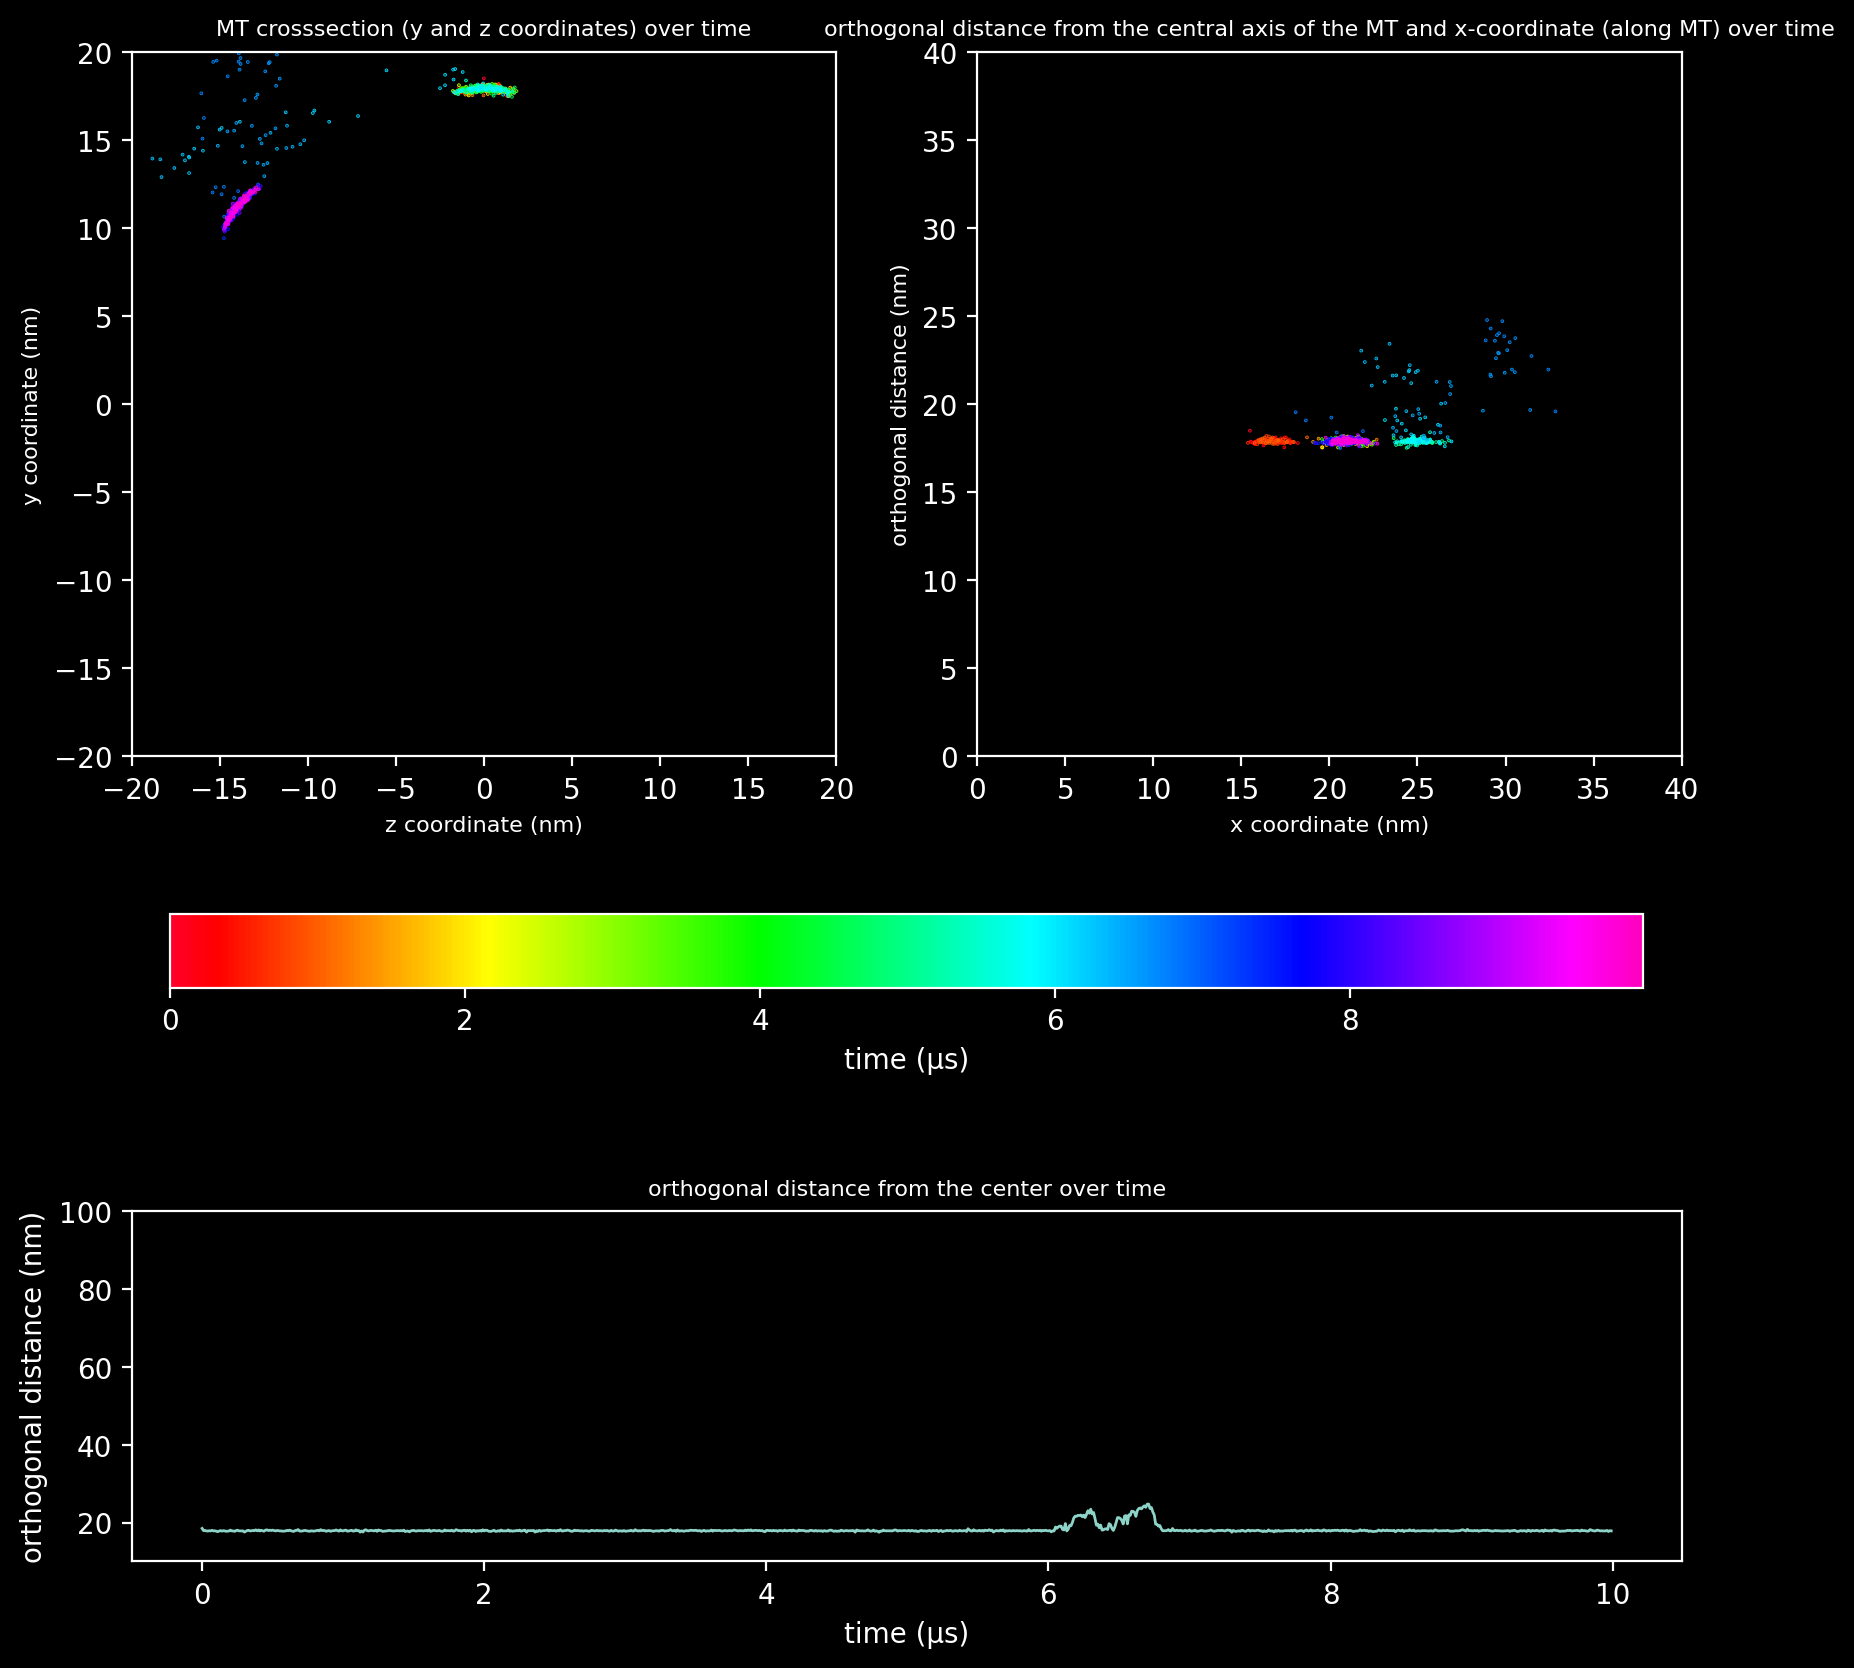

Elapsed (after compilation) = 25.00883945901296s
Engine 2:


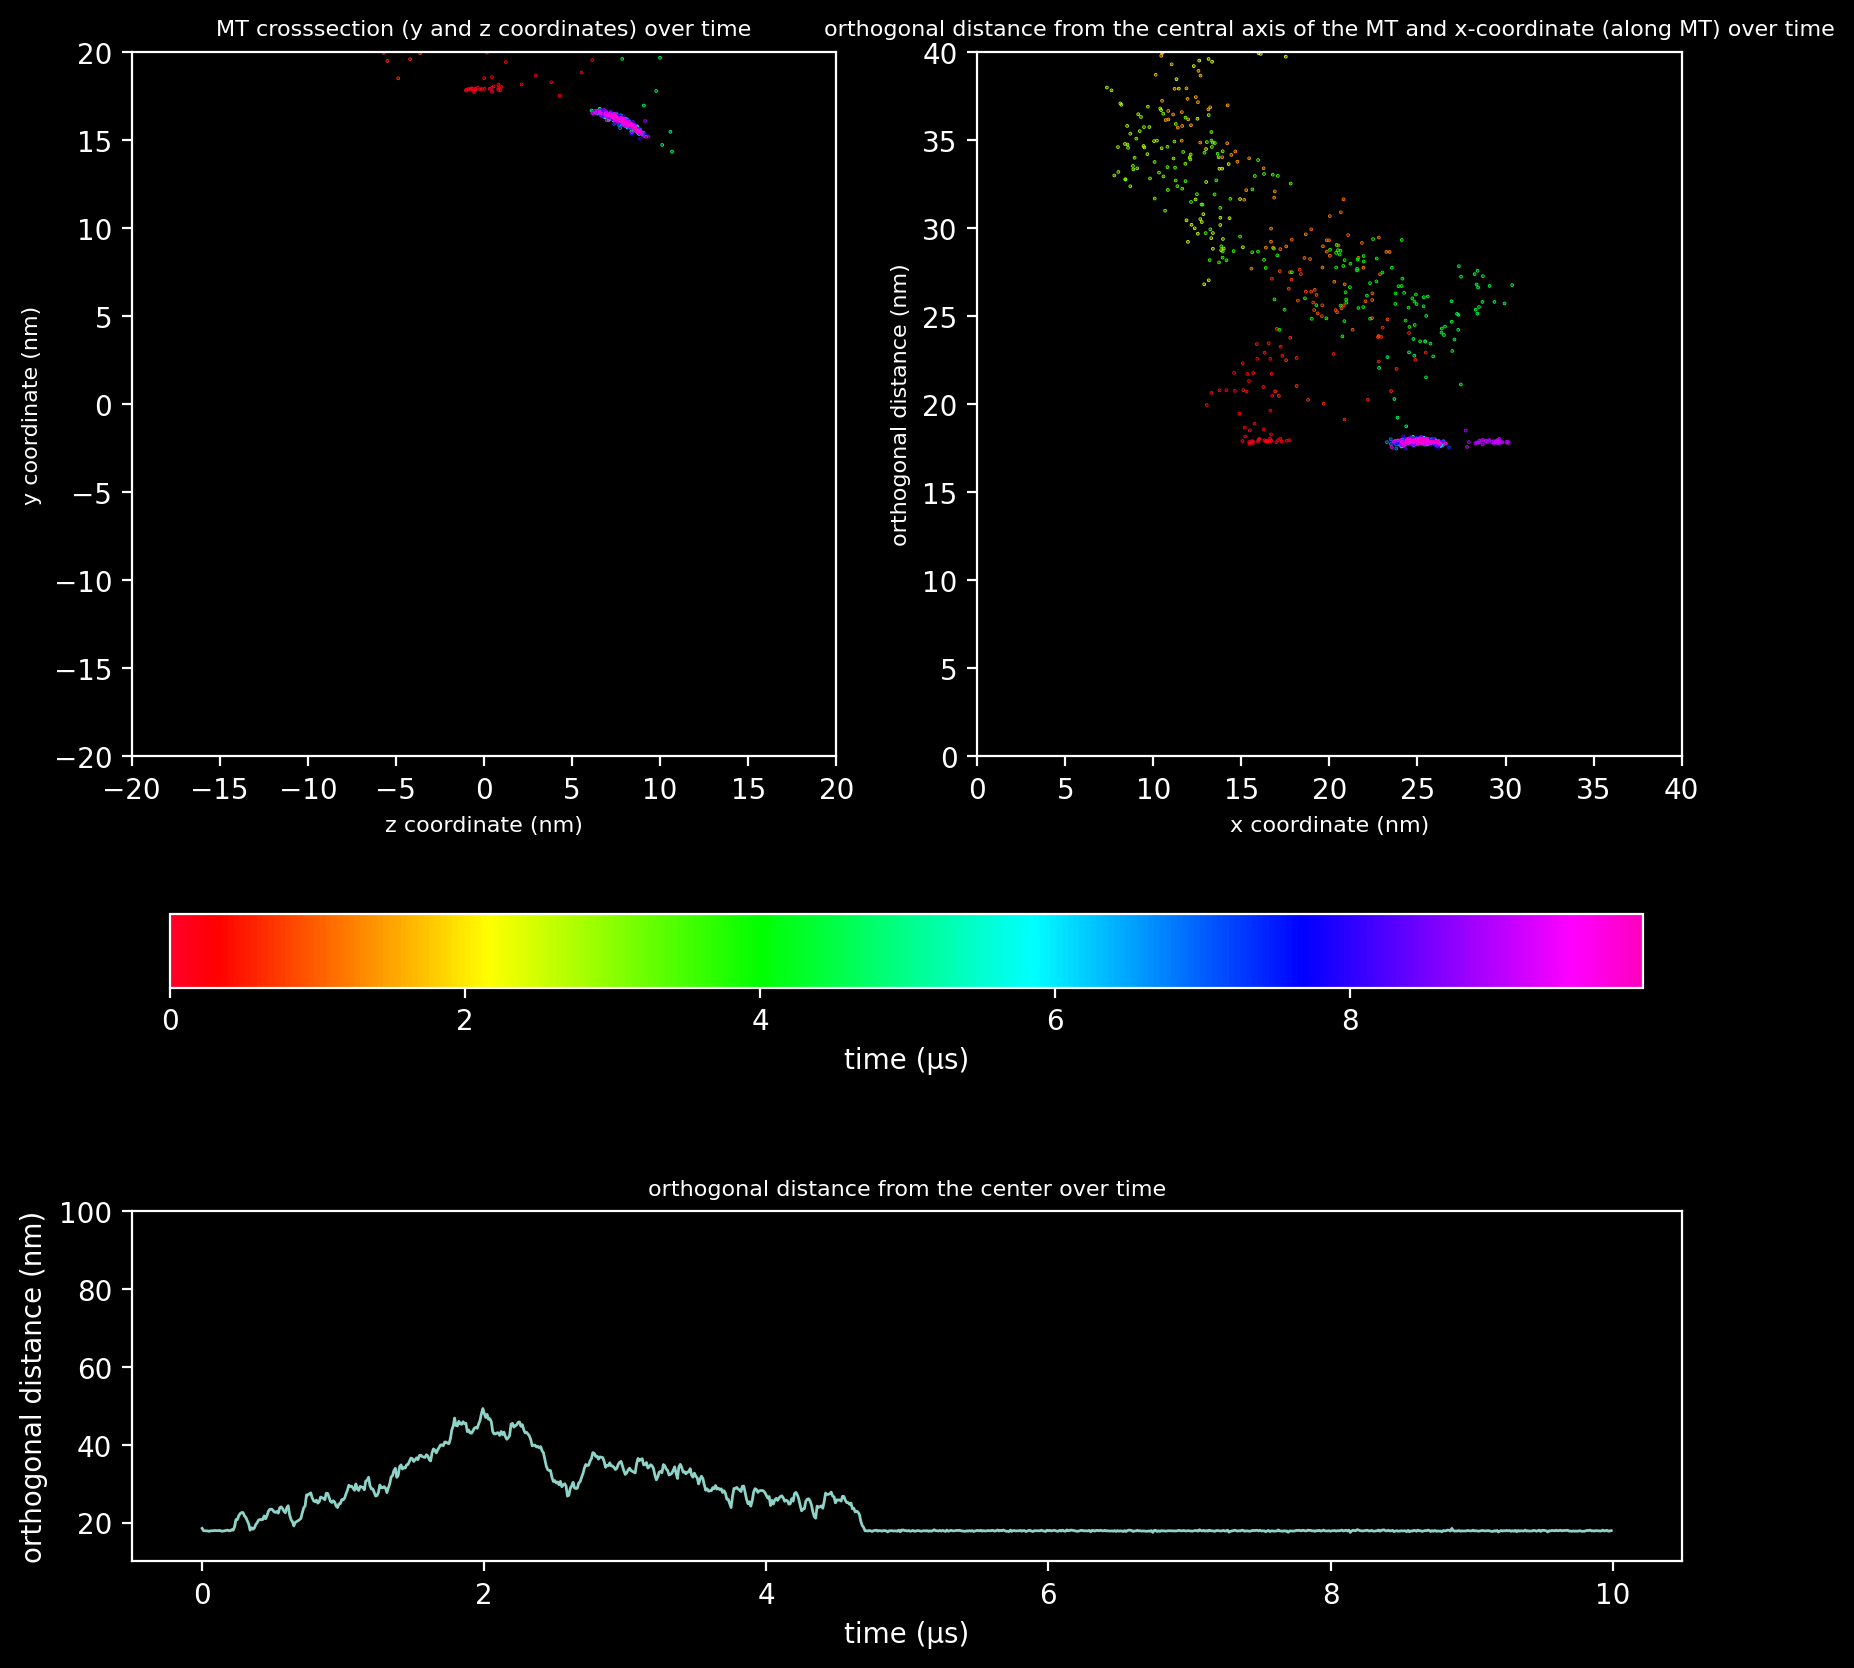

Elapsed (after compilation) = 25.10192695801379s
Engine 3:


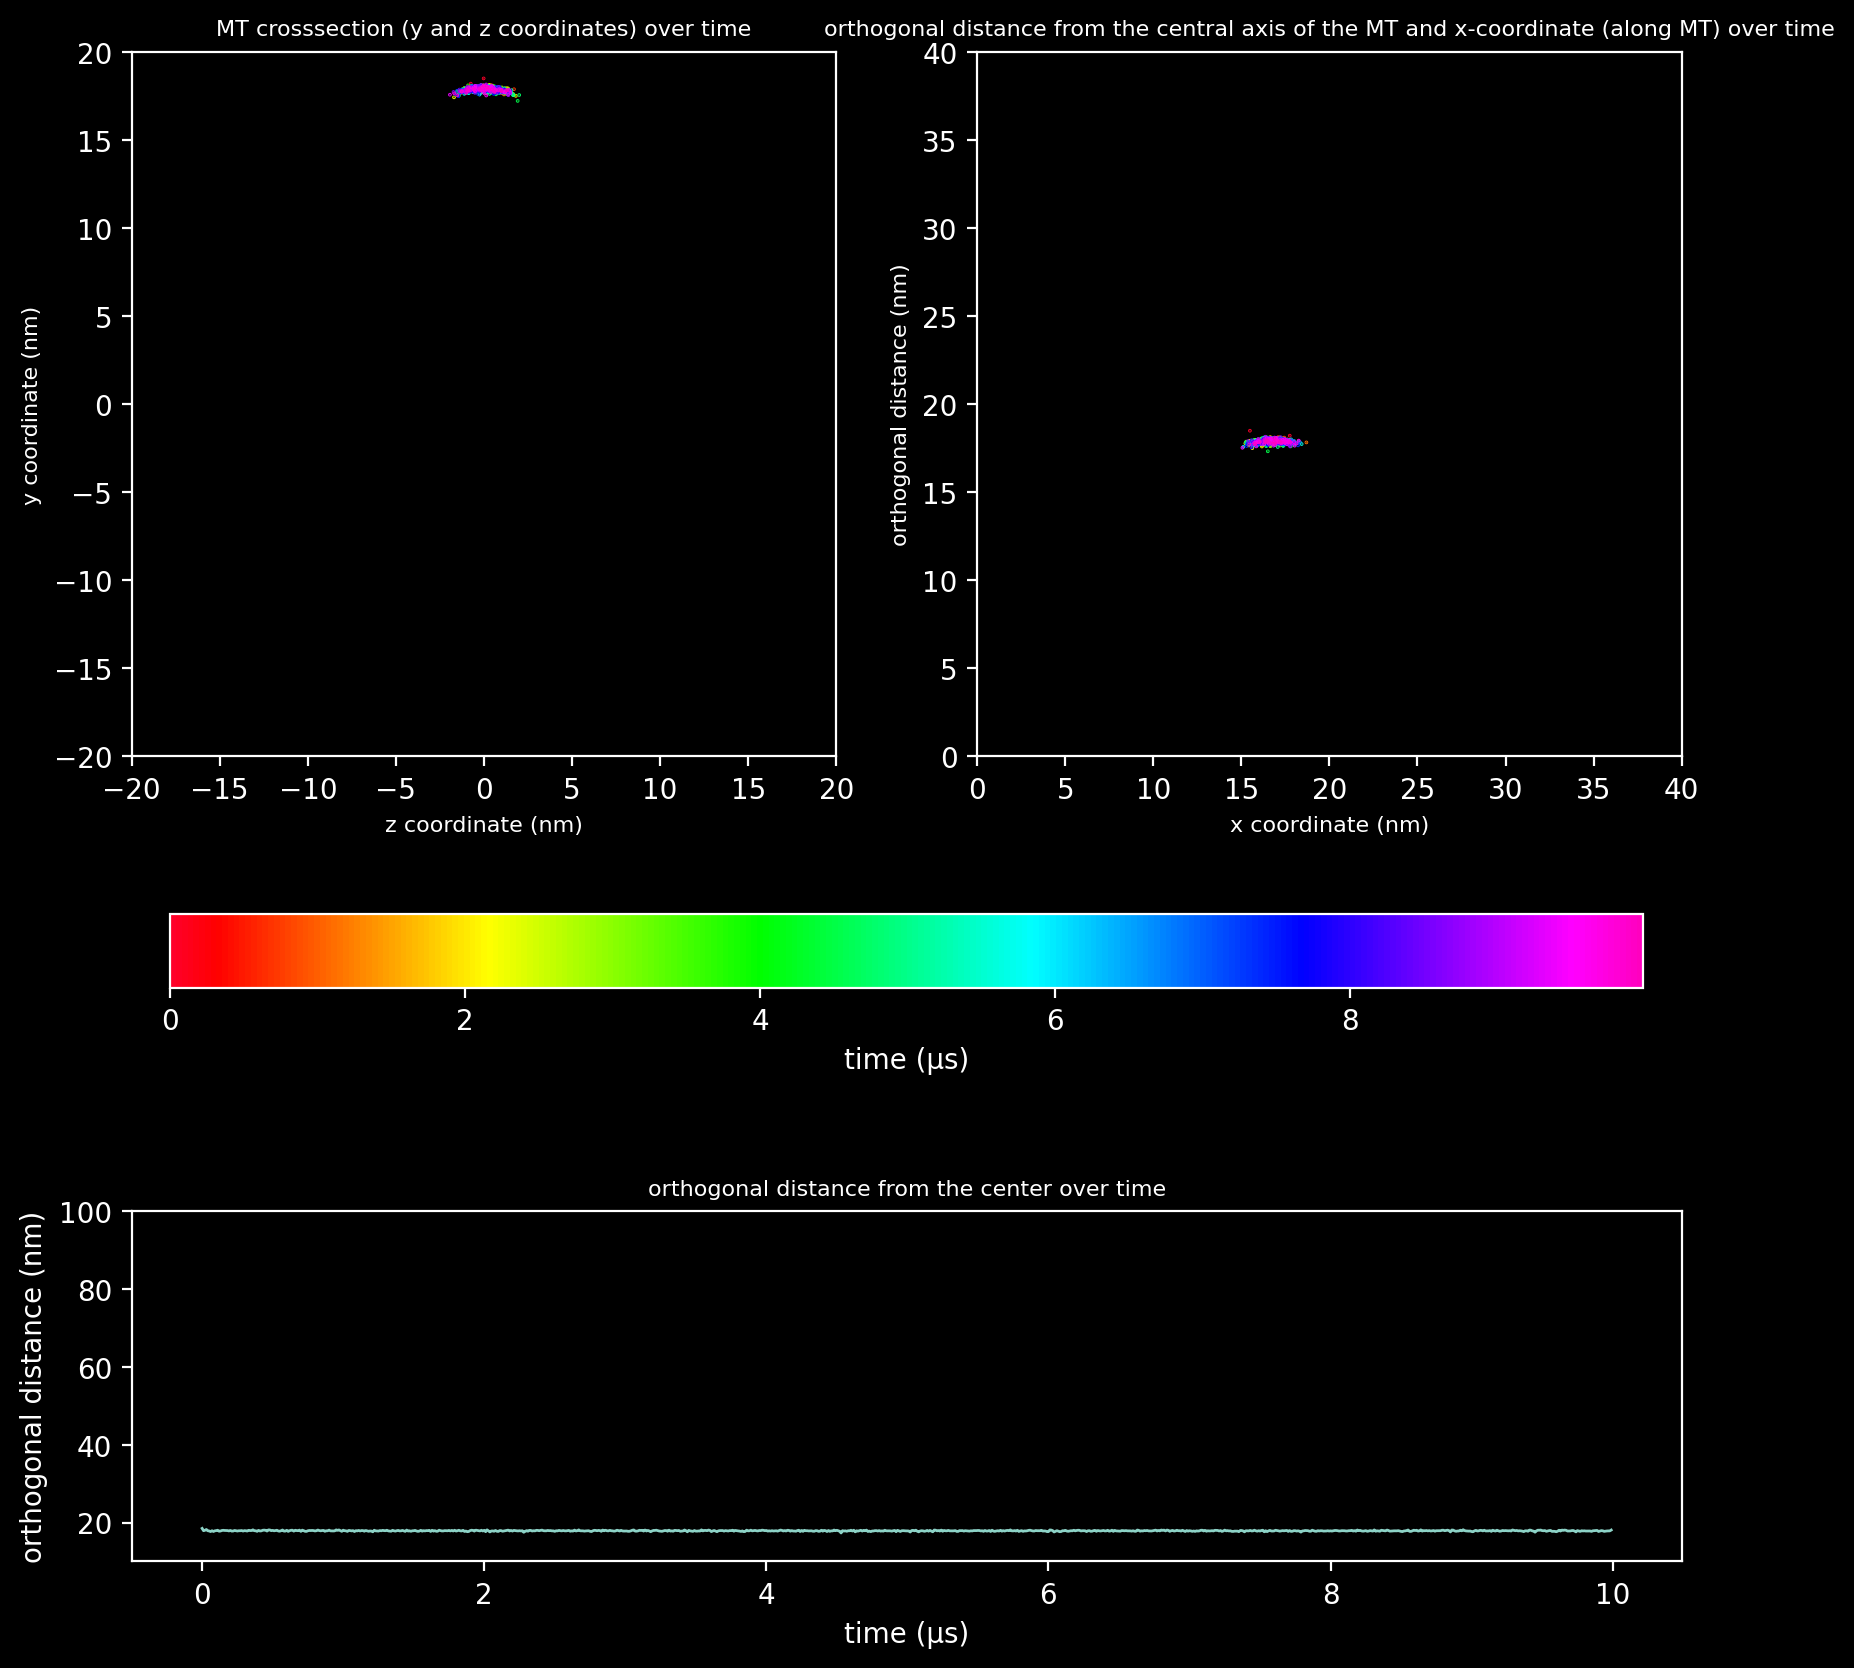

Elapsed (after compilation) = 25.222314999991795s
Engine 4:


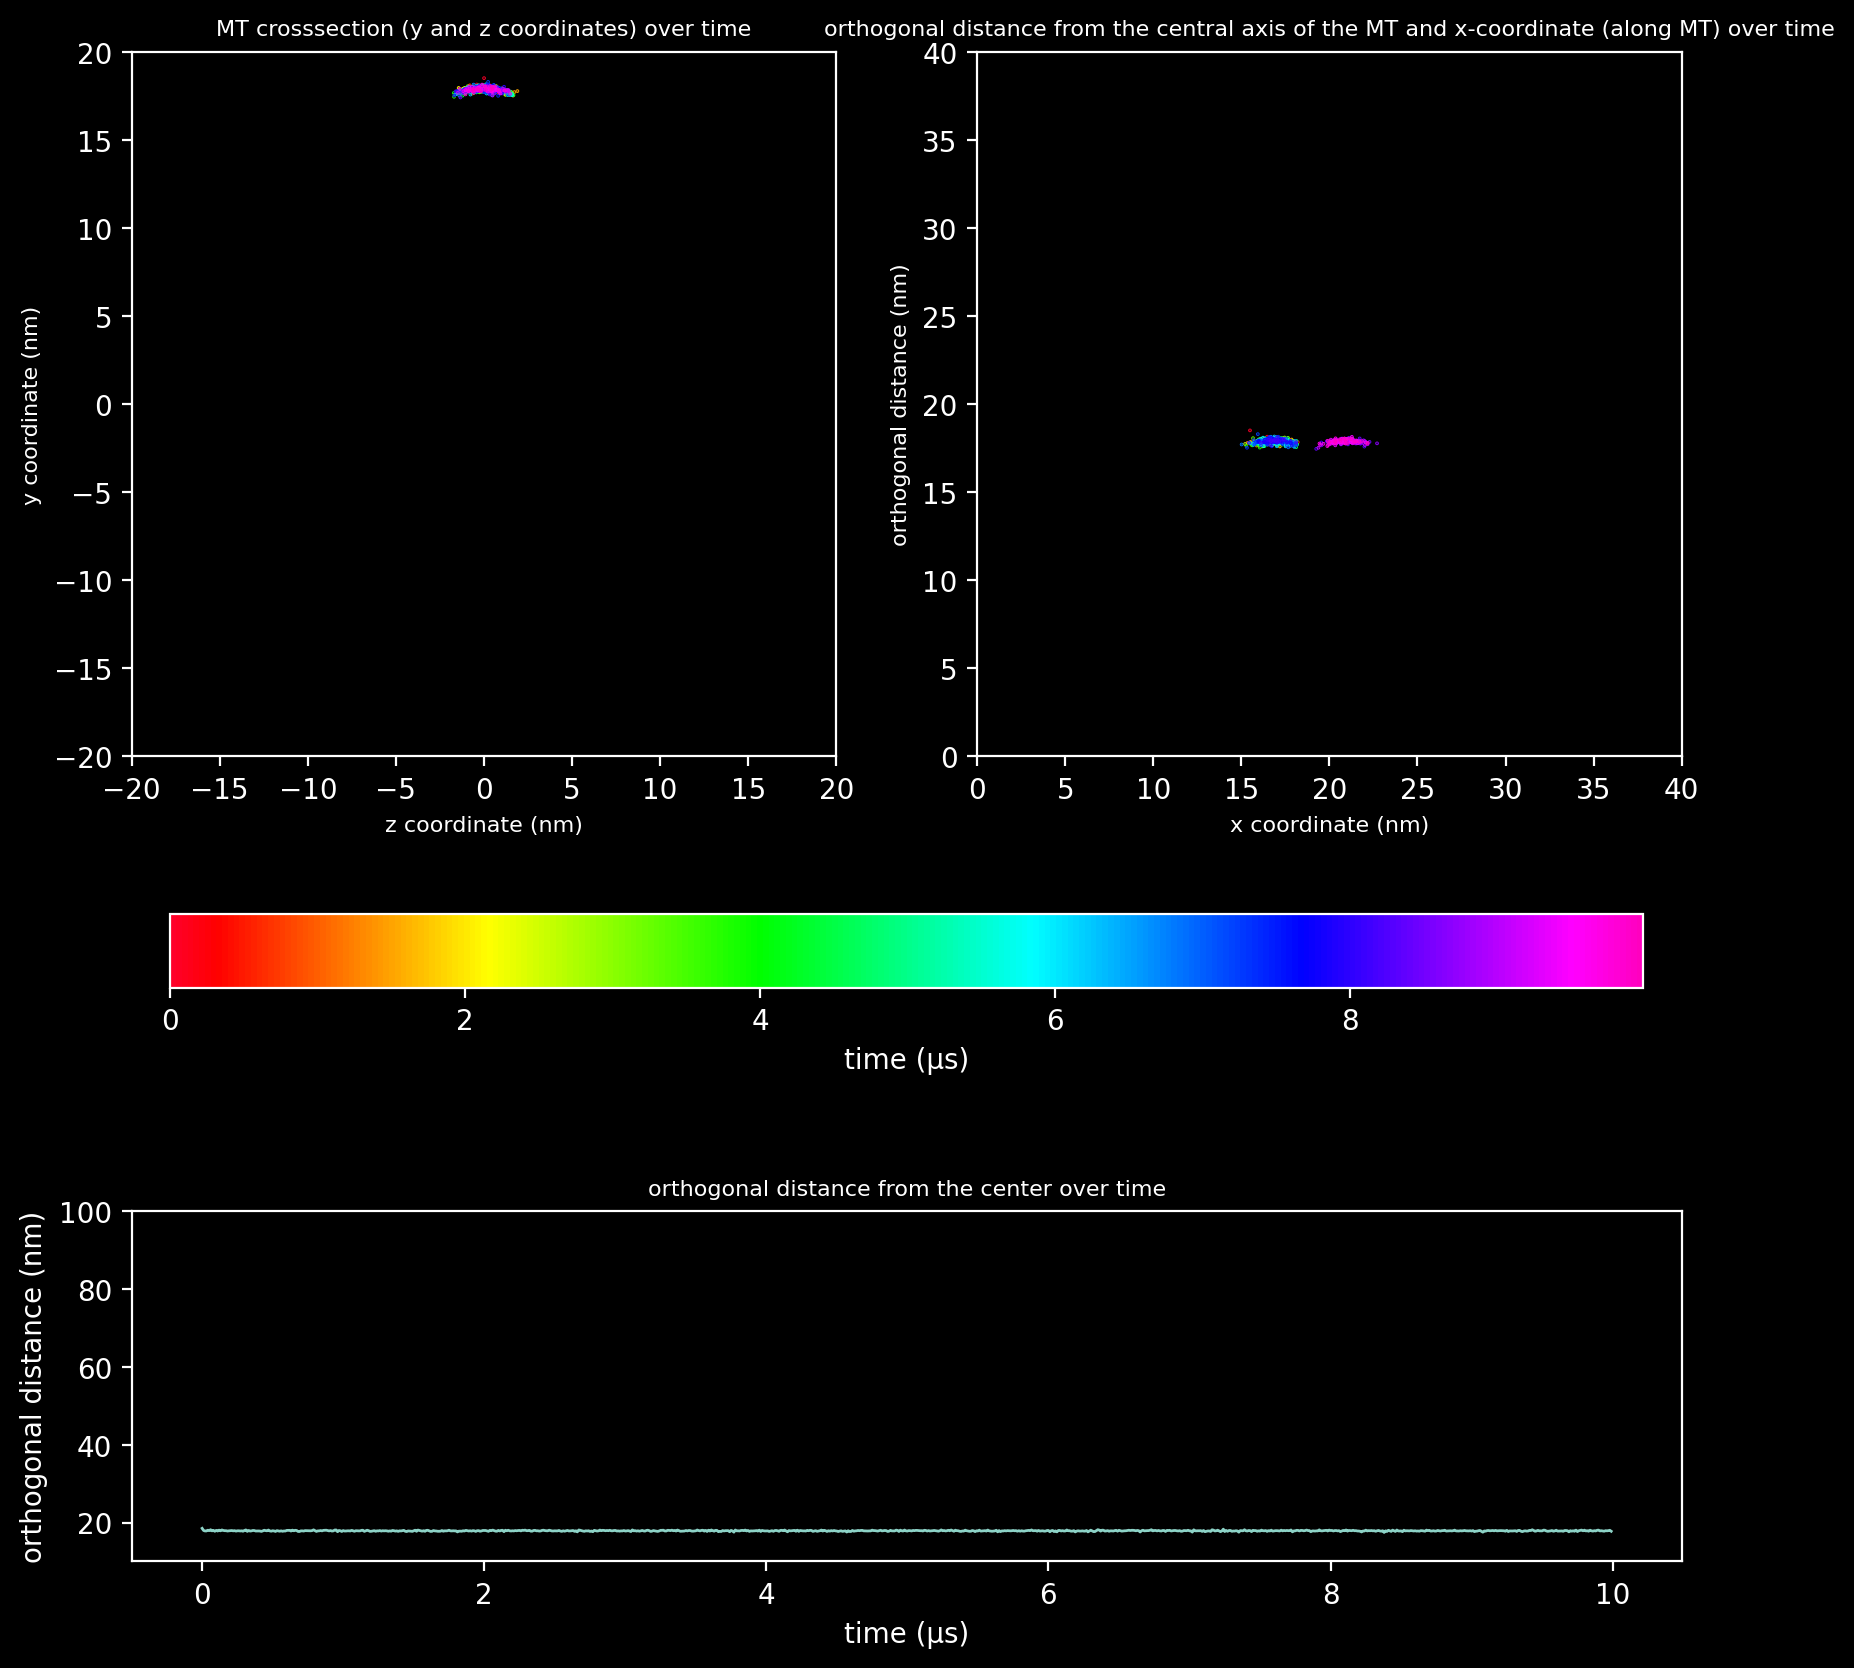

Elapsed (after compilation) = 25.622076458996162s
Engine 5:


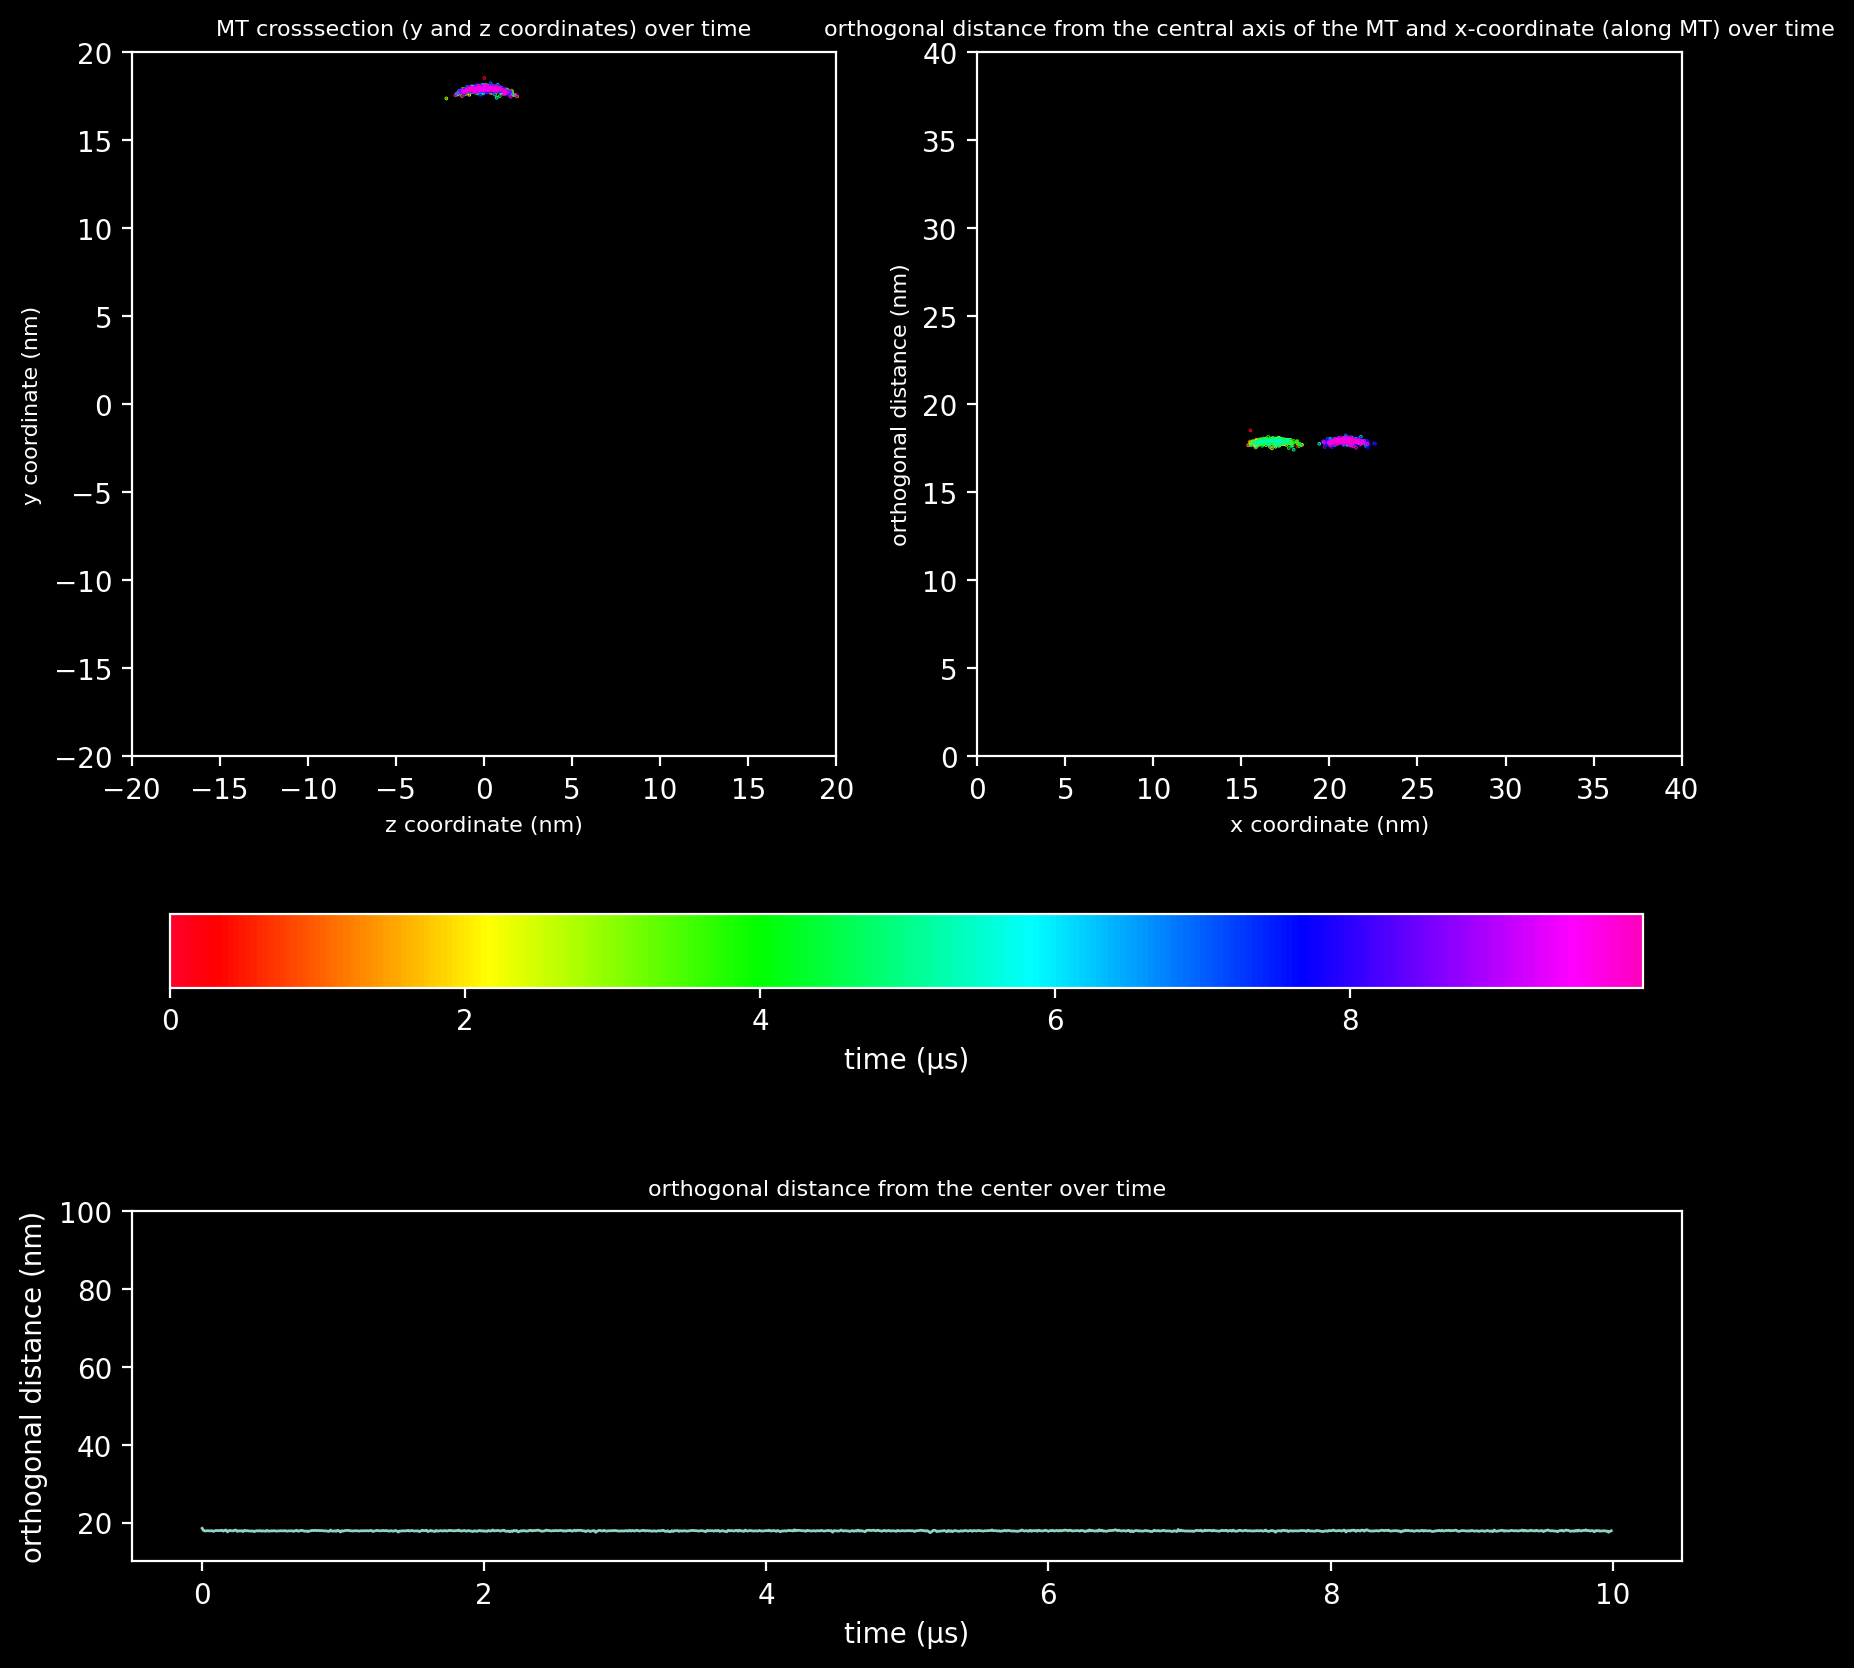

Elapsed (after compilation) = 25.432188208011212s
Engine 6:


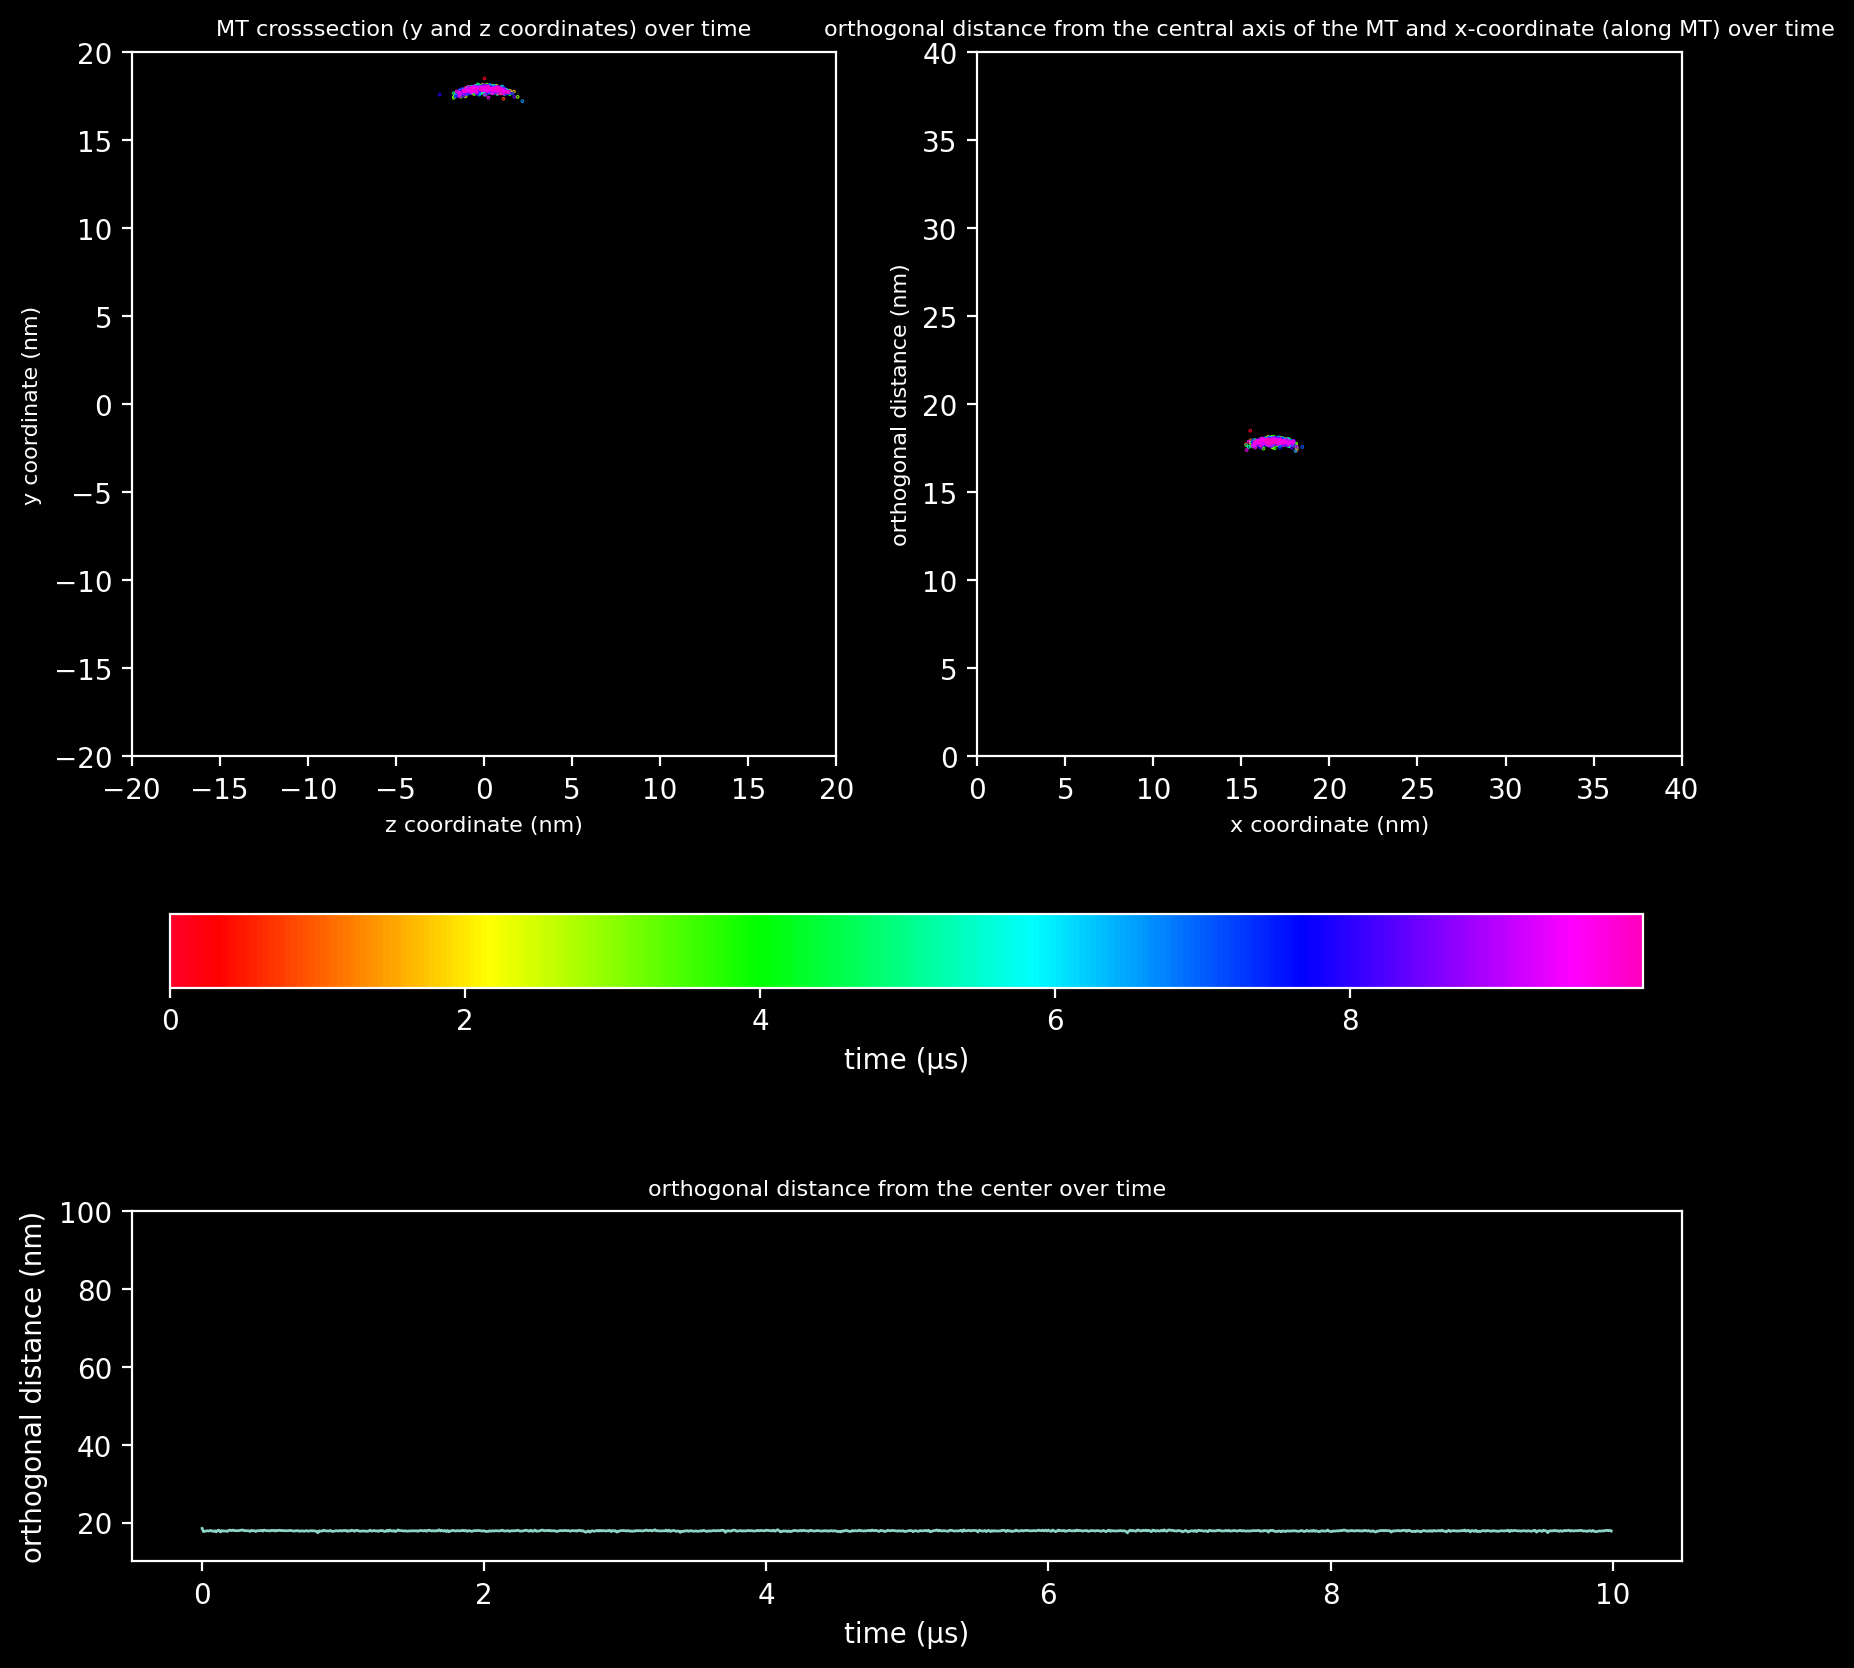

Elapsed (after compilation) = 24.90378691701335s
Engine 7:


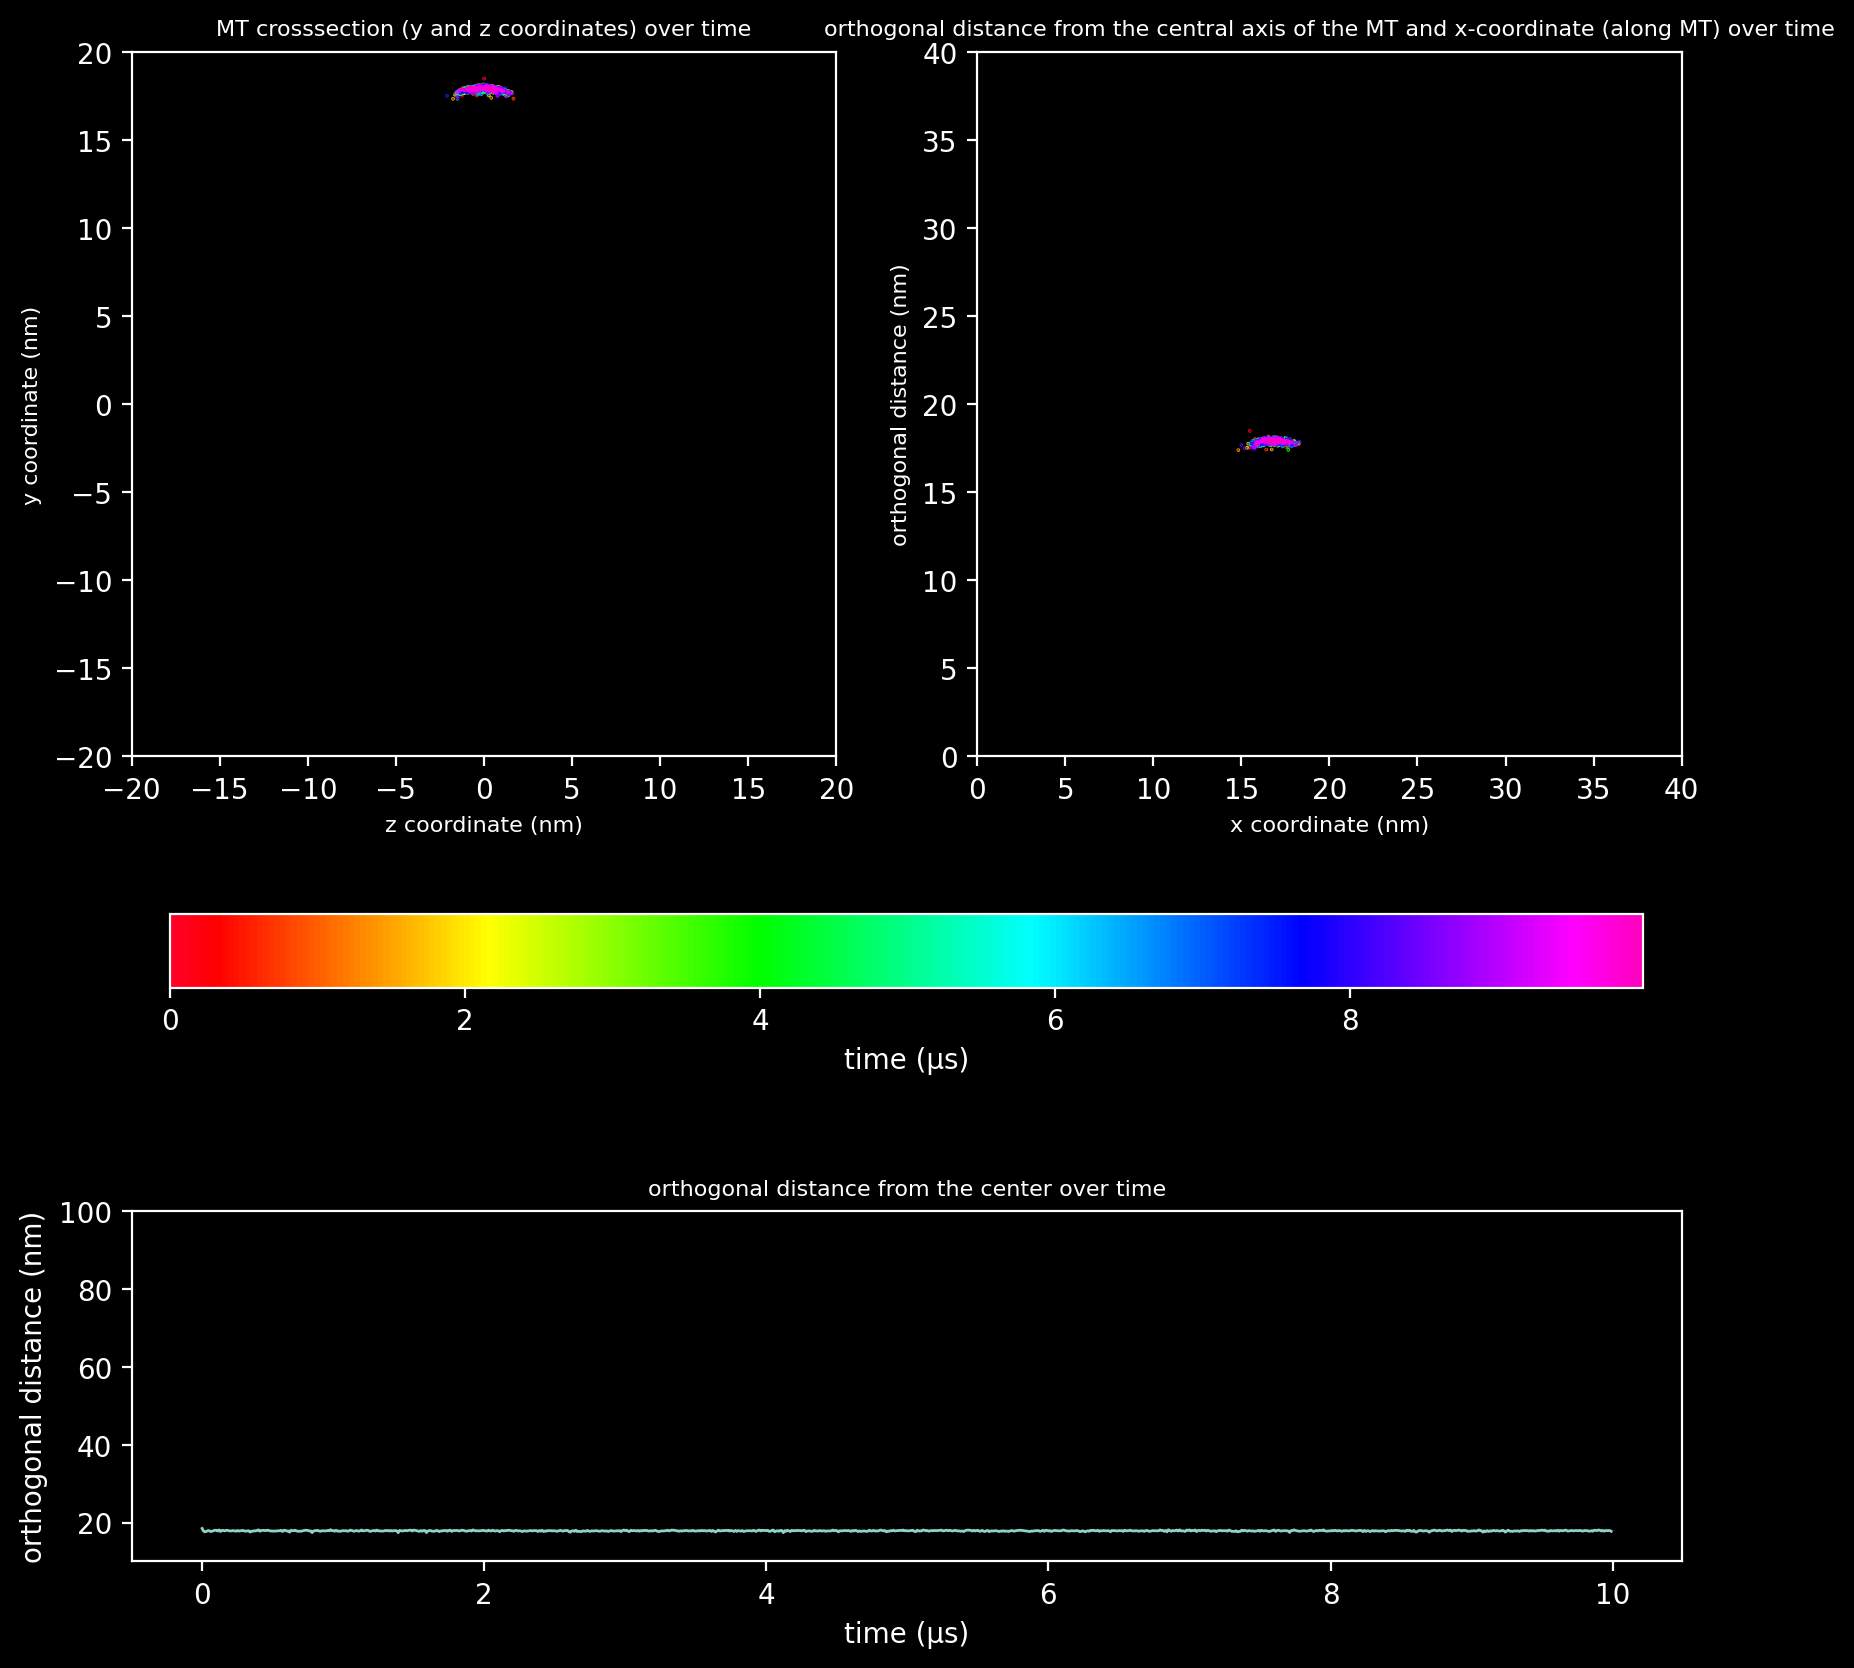

Elapsed (after compilation) = 25.460296749981353s


In [40]:
for idx, res in enumerate(results):
    print(f"Engine {idx}:")
    plotter(res['headhist'], idx, True)
    print("Elapsed (after compilation) = {}s".format((res['elapsed'])))

In [ ]:
# ALTERNATIVE PLOTTER
import holoviews as hv
import datashader as ds
import holoviews.operation.datashader as hd
import pandas as pd
import numpy as np

hv.extension('bokeh')

# Use the same subsampling as before
render_everyN = 1
# Create a time array for the rendered points
time_arr = np.arange(steps/(render_everyN*hist_every))

# Prepare DataFrames for the two plots.
# Plot 1: Scatter of COM x vs. COM y
df1 = pd.DataFrame({
    'x': headhist[::render_everyN, 0],
    'y': headhist[::render_everyN, 1],
    'time': headhist[::render_everyN, 0] * 0.0 + time_arr  # associate time (or use headhist if desired)
})

# Plot 2: Scatter of COM x vs. orthogonal distance
orthogonal_distance = np.linalg.norm(headhist[::render_everyN, 1:3], axis=1)
df2 = pd.DataFrame({
    'x': headhist[::render_everyN, 0],
    'y': orthogonal_distance,
    'time': time_arr
})

# Create Holoviews Points objects.
points1 = hv.Points(df1, kdims=['x', 'y'], vdims=['time'])
points2 = hv.Points(df2, kdims=['x', 'y'], vdims=['time'])

# Apply Datashader to each plot for interactive aggregation.
shaded1 = hd.datashade(points1, cmap="gist_rainbow", aggregator=ds.mean('time'))
shaded2 = hd.datashade(points2, cmap="gist_rainbow", aggregator=ds.mean('time'))

# Set options (titles, colorbars, dimensions, etc.)
shaded1 = shaded1.opts(title="COM Trajectory (x vs. y)",
                       frame_width=600, frame_height=400, bgcolor='black')
shaded2 = shaded2.opts(title="COM Trajectory (x vs. Orthogonal Distance)",
                       frame_width=600, frame_height=200, bgcolor='black')

# Layout the two plots vertically.
layout = hv.Layout([shaded1, shaded2]).cols(1)
layout

In [ ]:
mysum = 0
for n in range(10): mysum+=(results[n])["elapsed"]
mysum / 9  # 239s avg to run for 9 processes
mysum / 10  # 251s avg, 4min30 overall
300 / 12  # 5min 15s in total for 12 processes

In [97]:
n = 10000000
x = np.zeros(n, dtype=int)

@njit()
def numbaspeedtest(x):
    for i in range(n):
        r = np.pi/(i+1)
        #r1 = np.array([r, r+1.0, r+2])
        x[i] = r - x[i-1]
        #np.linalg.norm(r1)
        #x[i] = np.sqrt(r*r + (r+1)*(r+1) + (r+2)*(r+2))

In [98]:
start = time.perf_counter()
numbaspeedtest(x)
end = time.perf_counter()
print(end - start)

0.6827912500011735
